# Modélisation prédictive des coûts de sinistre dans l'assurance des travailleurs

## 1 - Importation et Nettoyage des données

#### 1. i. Importation des données :

In [202]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import datetime
from collections import Counter
import re

from scipy.stats import randint, uniform
from scipy.stats import wilcoxon

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.base import clone

from xgboost import XGBRegressor
from catboost import CatBoostRegressor



In [203]:
df_train = pd.read_csv("train.csv", index_col = "ClaimNumber")
df_test = pd.read_csv("test.csv", index_col = "ClaimNumber")
df_submission = pd.read_csv("sample_submission.csv", index_col = "ClaimNumber")


In [204]:
df_train.head(10)

DateTimeOfAccident          DateReported  Age Gender  \
ClaimNumber                                                           
WC8285054    2002-04-09T07:00:00Z  2002-07-05T00:00:00Z   48      M   
WC6982224    1999-01-07T11:00:00Z  1999-01-20T00:00:00Z   43      F   
WC5481426    1996-03-25T00:00:00Z  1996-04-14T00:00:00Z   30      M   
WC9775968    2005-06-22T13:00:00Z  2005-07-22T00:00:00Z   41      M   
WC2634037    1990-08-29T08:00:00Z  1990-09-27T00:00:00Z   36      M   
WC6828422    1999-06-21T11:00:00Z  1999-09-09T00:00:00Z   50      M   
WC8058150    2001-07-13T11:00:00Z  2001-07-23T00:00:00Z   39      M   
WC7539849    2000-03-09T09:00:00Z  2000-04-16T00:00:00Z   56      M   
WC4427179    1994-03-24T16:00:00Z  1994-04-26T00:00:00Z   49      M   
WC9907636    2005-12-07T11:00:00Z  2005-12-22T00:00:00Z   30      M   

            MaritalStatus  DependentChildren  DependentsOther  WeeklyWages  \
ClaimNumber                                                                  
WC8285054               M                  0                0       500.00   
WC6982224               M                  0                0       509.34   
WC5481426               U                  0                0       709.10   
WC9775968               S                  0                0       555.46   
WC2634037               M                  0                0       377.10   
WC6828422               M                  0                0       200.00   
WC8058150               M                  0                0       200.00   
WC7539849               M                  0                0       200.00   
WC4427179               M                  0                0       623.60   
WC9907636               S                  0                0       857.28   

            PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek  \
ClaimNumber                                                           
WC8285054                  F                38.0                  5   
WC6982224                  F                37.5                  5   
WC5481426                  F                38.0                  5   
WC9775968                  F                38.0                  5   
WC2634037                  F                38.0                  5   
WC6828422                  F                38.0                  5   
WC8058150                  F                38.0                  5   
WC7539849                  F                40.0                  5   
WC4427179                  F                38.0                  5   
WC9907636                  F                37.0                  5   

                                              ClaimDescription  \
ClaimNumber                                                      
WC8285054    LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY   
WC6982224    STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...   
WC5481426                     CUT ON SHARP EDGE CUT LEFT THUMB   
WC9775968                 DIGGING LOWER BACK LOWER BACK STRAIN   
WC2634037    REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...   
WC6828422                   STRUCK HEAD ON HEAD LACERATED HEAD   
WC8058150                  FINGER BRUISED AND SWOLLEN LEFT ARM   
WC7539849            CLEANING LEFT SHOULDER SPLINTER LEFT HAND   
WC4427179    JACK SLIPPED CATCHING FINGER CUT LEFT LITTLE F...   
WC9907636        STRUCK PINE DUST ABRASION LEFT EYE IRRITATION   

             InitialIncurredCalimsCost  UltimateIncurredClaimCost  
ClaimNumber                                                        
WC8285054                         1500                4748.203388  
WC6982224                         5500                6326.285819  
WC5481426                         1700                2293.949087  
WC9775968                        15000               17786.487170  
WC2634037                         2800                4014.002925  
WC6828422                          500                 598.762315  
WC8058150                          

In [205]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         54000 non-null  object 
 1   DateReported               54000 non-null  object 
 2   Age                        54000 non-null  int64  
 3   Gender                     54000 non-null  object 
 4   MaritalStatus              53971 non-null  object 
 5   DependentChildren          54000 non-null  int64  
 6   DependentsOther            54000 non-null  int64  
 7   WeeklyWages                54000 non-null  float64
 8   PartTimeFullTime           54000 non-null  object 
 9   HoursWorkedPerWeek         54000 non-null  float64
 10  DaysWorkedPerWeek          54000 non-null  int64  
 11  ClaimDescription           54000 non-null  object 
 12  InitialIncurredCalimsCost  54000 non-null  int64  
 13  UltimateIncurredClaimCost  54000 non-nu

###### La base de données est constituée de variables décrivant : 
    Le travailleur : Age, Gender, MaritalStatut, DependentChildren, DependentsOther.
    Le travail : WeeklyWages, PartTimeFullTime, HoursWorkedPerWeek, DaysWorkedPerWeek.
    Les sinistres : DateTimeOfAccident, DateReported, ClaimDescription, InitialIncurredClaimsCost, 
                    UltimeIncurredClaimCost (variable à prédire)

#### 1. ii. Nettoyage des données :

In [206]:
df_train.drop_duplicates().shape

(54000, 14)

In [207]:
df_train.isnull().sum()

DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                29
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
dtype: int64

La variable 'MaritalStatus' contient des valeurs manquantes qui représente 0.05% de la base. Dans ce cas, et afin de les garder dans la base, nous allons voir la catégorie de la varibale la plus représentée dans la base afin de les recodifier sur cette
catégorie de la variable.

In [208]:
df_nan_MaritalStatus = df_train[df_train['MaritalStatus'].isnull()]
df_nan_MaritalStatus['UltimateIncurredClaimCost'].agg(['count','median','mean'])

count       29.000000
median    1481.957757
mean      5325.896064
Name: UltimateIncurredClaimCost, dtype: float64

In [209]:
print(df_train['UltimateIncurredClaimCost'].groupby(df_train['MaritalStatus']).agg(['count','median','mean']))

               count       median          mean
MaritalStatus                                  
M              22516  4166.460054  12024.933597
S              26161  2322.799731   9105.578095
U               5294  5851.980317  16067.822199


La variable 'MaritalStatus' contient trois catégories, M : Married, S : Single, U : Unknown.
La catégorie 'S' est la plus représentée avec des coûts ultimes moyen de 9105.58$. 
Nous allons recodifier les valeurs manquantes avec cette catégorie.

In [210]:
df_train = df_train.fillna('S')

## 2 - EDA : Analyse Exploratoire des données 

#### 2.i. Analyse descriptive des variables quantitatives : 

In [211]:
df_train.describe().T

count          mean           std         min  \
Age                        54000.0     33.842370     12.122165   13.000000   
DependentChildren          54000.0      0.119185      0.517780    0.000000   
DependentsOther            54000.0      0.009944      0.109348    0.000000   
WeeklyWages                54000.0    416.364807    248.638669    1.000000   
HoursWorkedPerWeek         54000.0     37.735084     12.568704    0.000000   
DaysWorkedPerWeek          54000.0      4.905759      0.552129    1.000000   
InitialIncurredCalimsCost  54000.0   7841.146019  20584.075006    1.000000   
UltimateIncurredClaimCost  54000.0  11003.369169  33390.991292  121.886805   

                                  25%         50%          75%          max  
Age                         23.000000    32.00000    43.000000       81.000  
DependentChildren            0.000000     0.00000     0.000000        9.000  
DependentsOther              0.000000     0.00000     0.000000        5.000  
WeeklyWages                200.000000   392.20000   500.000000     7497.000  
HoursWorkedPerWeek          38.000000    38.00000    40.000000      640.000  
DaysWorkedPerWeek            5.000000     5.00000     5.000000        7.000  
InitialIncurredCalimsCost  700.000000  2000.00000  9500.000000  2000000.000  
UltimateIncurredClaimCost  926.338449  3371.24173  8197.248648  4027135.935

Il y a des variables quantitatives continues comme Age, WeeklyWages, HoursWorkedPerWeek, InitialIncurredCalimsCost,
d'autres variables sont discrétes comme DependentChildren, DependentsOther.

La base représente une population assez jeune (âge moyen 34 ans), avec une présence de mineurs (âge min de 13 ans),
la variable âge semble être légèrement asymétrique vers la droite (Q75 âge de 43 ans et l'âge max de 81 ans).

Les variables DependentChildren et DependsOther sont quasi-constantes (std quasi-null) et plus de 75% des obs sont null.
                                                                   
Présence des valeurs null dans la variables HoursWorkedPerWeek !!

L'existance des valeurs abérrantes surtout dans les variables WeeklyWages, HoursWorkedPerWeek, et IntialIncurredClaimsCost
=> Transformation ou cap des variables est fortement recommandé.

In [212]:
df_train['DateTimeOfAccident'] = pd.to_datetime(df_train['DateTimeOfAccident'])
df_train['DateReported'] = pd.to_datetime(df_train['DateReported'])

df_train['annee_sinistre'] = df_train['DateTimeOfAccident'].dt.year
df_train['mois_sinistre'] = df_train['DateTimeOfAccident'].dt.month
df_train['annee_declaration'] = df_train['DateReported'].dt.year
df_train['mois_declaration'] = df_train['DateReported'].dt.month

#on ajoute le délai entre la date de sinistre et la date de déclaration de sinistre
df_train['int_declar_jour'] = (df_train['DateReported'] - df_train['DateTimeOfAccident']).dt.days
df_train['int_declar_sem'] = (df_train['DateReported'] - df_train['DateTimeOfAccident']).dt.days//7

#Salaire horraire 
df_train['HourWages'] = np.where(
    (df_train['HoursWorkedPerWeek'] > 0) & (~df_train['HoursWorkedPerWeek'].isna()),
    df_train['WeeklyWages'] / df_train['HoursWorkedPerWeek'],
    np.nan)

#transformer les deux variables pour mieux gérer les valeurs extremes
df_train["LogUltimateIncurredClaimCost"] = np.log1p(df_train["UltimateIncurredClaimCost"])
df_train["LogInitialIncurredCalimsCost"] = np.log1p(df_train["InitialIncurredCalimsCost"])

df_train.drop(['DateTimeOfAccident', 'DateReported'],axis=1,inplace=True)
df_train.shape

(54000, 21)

#### 2.ii. Analyse Univariée : Visualisation des données

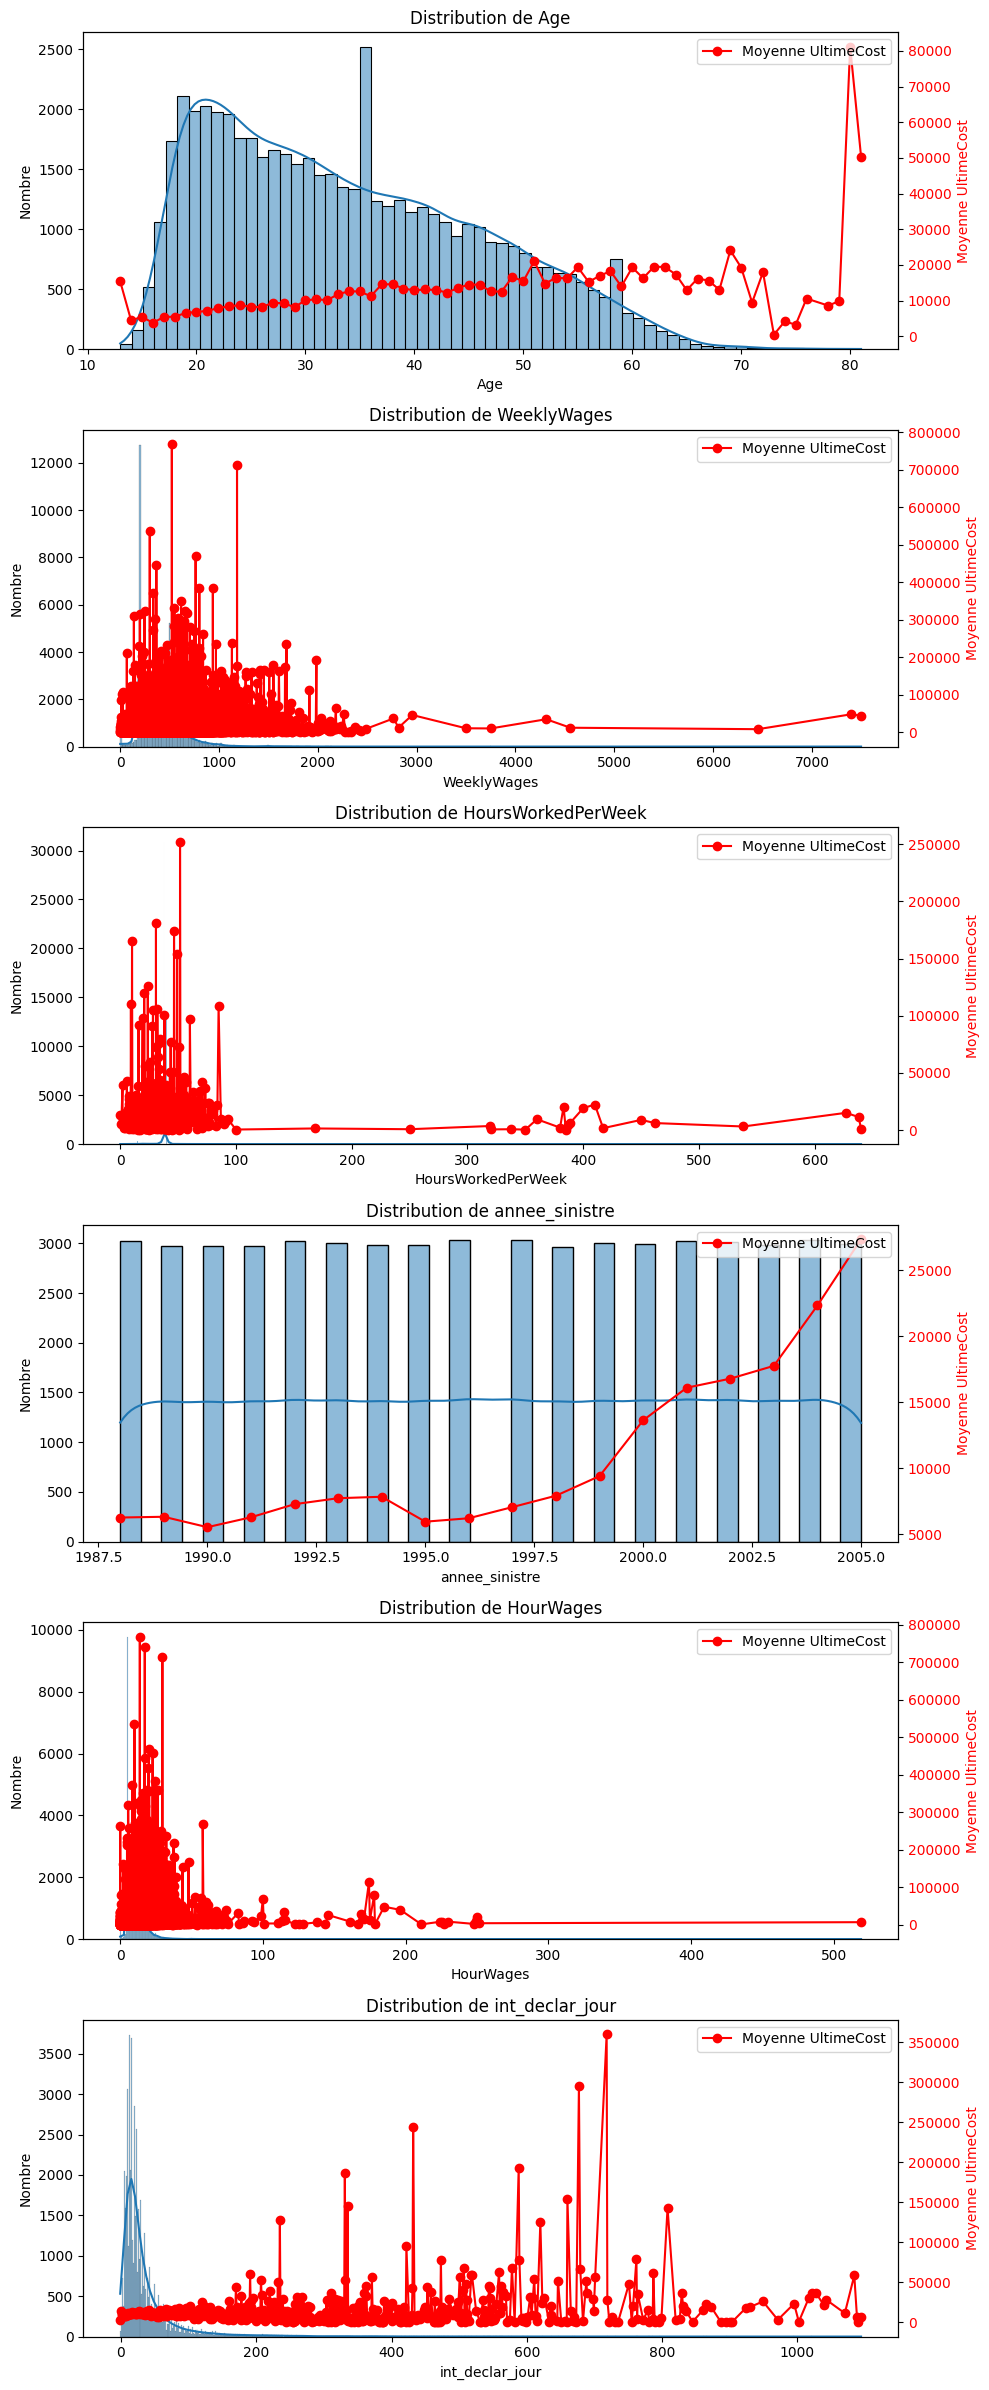

In [213]:
variables = ['Age', 'WeeklyWages',  'HoursWorkedPerWeek', 'annee_sinistre', 'HourWages', 'int_declar_jour']
n_vars = len(variables)

n_cols = 1
n_rows = (n_vars + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Histogramme + KDE
    sns.histplot(df_train[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Nombre')

    # Création du second axe y
    ax2 = axes[i].twinx()

    # Calcul de la moyenne de UltimeCost groupée par la variable
    # On évite les valeurs NaN
    grouped = df_train[[var, 'UltimateIncurredClaimCost']].dropna().groupby(var)['UltimateIncurredClaimCost'].mean()

    # Tracé de la moyenne
    ax2.plot(grouped.index, grouped.values, color='red', marker='o', linestyle='-', label='Moyenne UltimeCost')
    ax2.set_ylabel('Moyenne UltimeCost', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Optionnel : légende sur le second axe
    ax2.legend(loc='upper right')

# Supprimer les axes inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


il y'a des variables avec des valeurs extremes, on va les regarder de plus près en capant les variables au Q99

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3639817595.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()


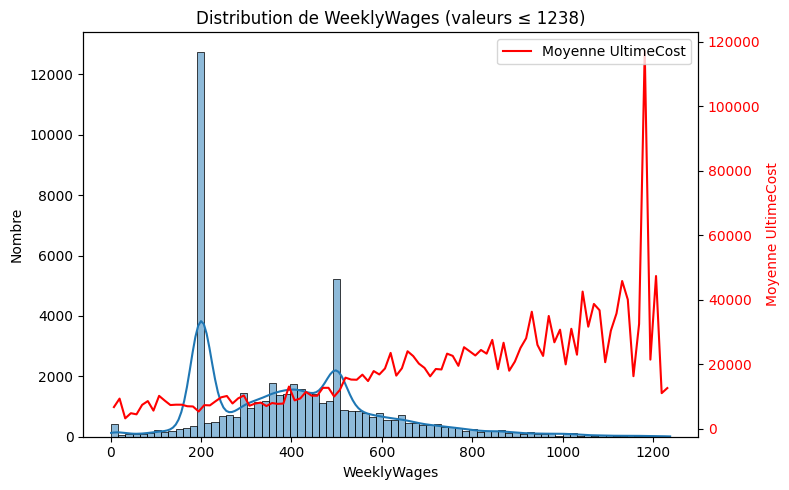

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3639817595.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()


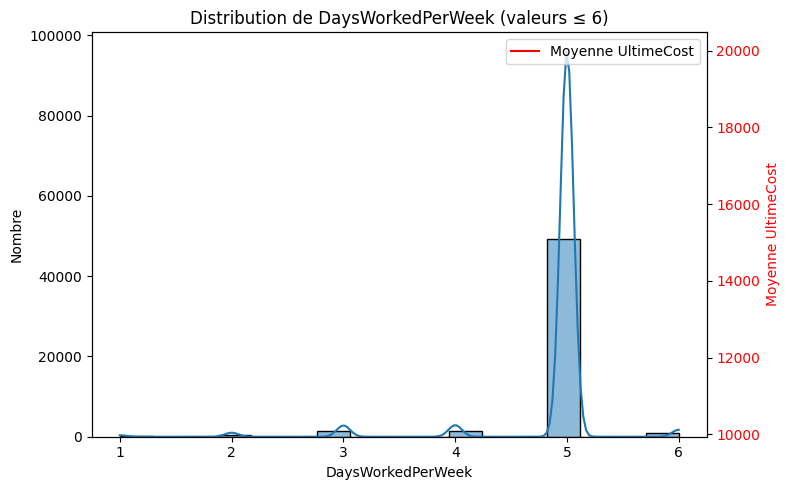

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3639817595.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()


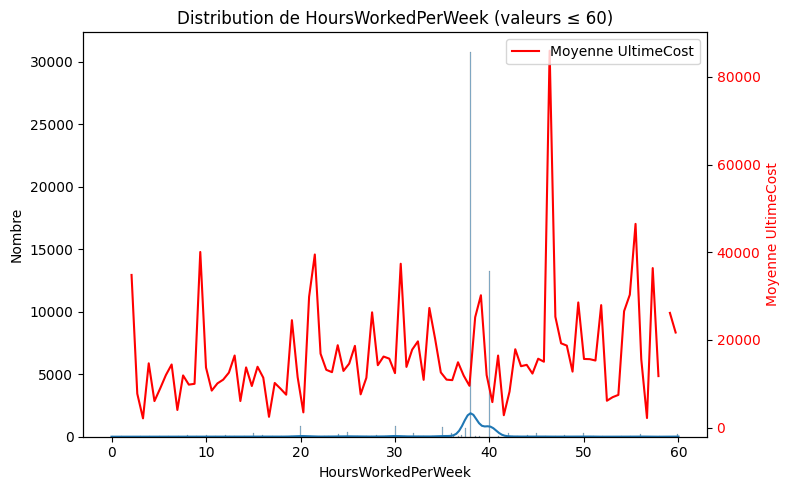

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3639817595.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()


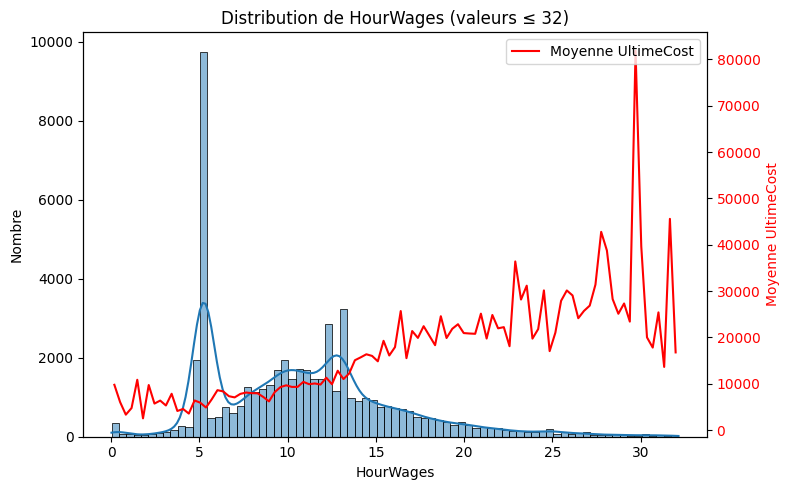

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3639817595.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()


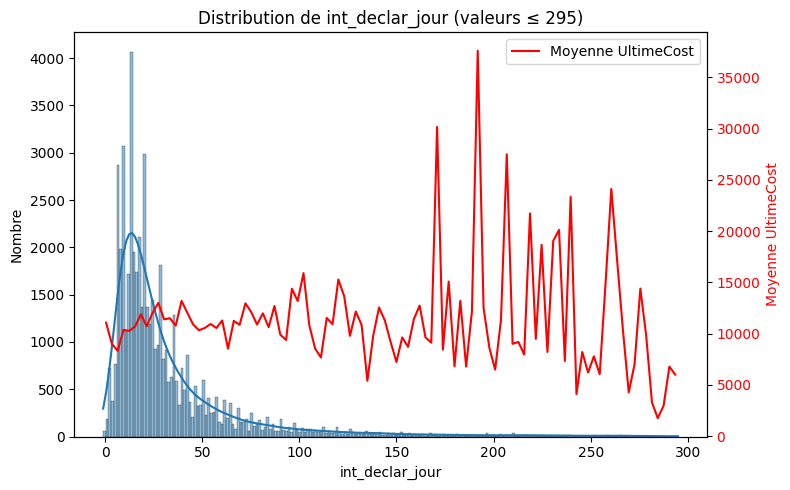

In [214]:
variables = ['WeeklyWages','DaysWorkedPerWeek', 'HoursWorkedPerWeek', 'HourWages', 'int_declar_jour']

for var in variables:
    # Calcul du 99e percentile pour limiter les outliers
    limite = df_train[var].quantile(0.99)

    # Filtrer les données
    df_filtered = df_train[df_train[var] <= limite].copy()  # .copy() pour éviter warning avec pd.cut

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Histogramme + KDE
    sns.histplot(df_filtered[var], kde=True, ax=ax1)
    ax1.set_xlabel(var)
    ax1.set_ylabel('Nombre')
    ax1.set_title(f'Distribution de {var} (valeurs ≤ {limite:.0f})')

    # Second axe y
    ax2 = ax1.twinx()

    # Création de bins
    bins = np.linspace(df_filtered[var].min(), df_filtered[var].max(), 100)
    df_filtered['bin'] = pd.cut(df_filtered[var], bins)

    # Moyenne UltimateIncurredClaimCost par bin
    grouped = df_filtered.groupby('bin')['UltimateIncurredClaimCost'].mean()
    bin_centers = bins[:-1] + np.diff(bins) / 2

    # Tracé de la moyenne
    ax2.plot(bin_centers, grouped.values, color='red',  linestyle='-', label='Moyenne UltimeCost')
    ax2.set_ylabel('Moyenne UltimeCost', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


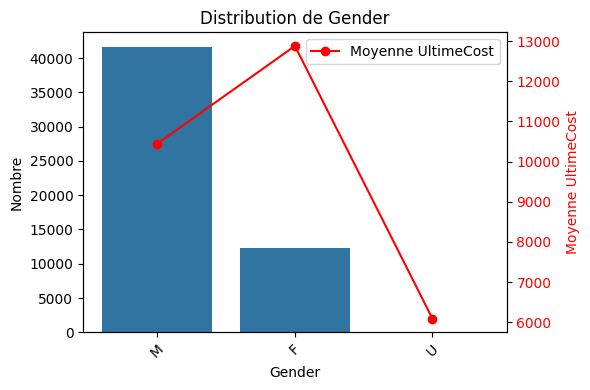

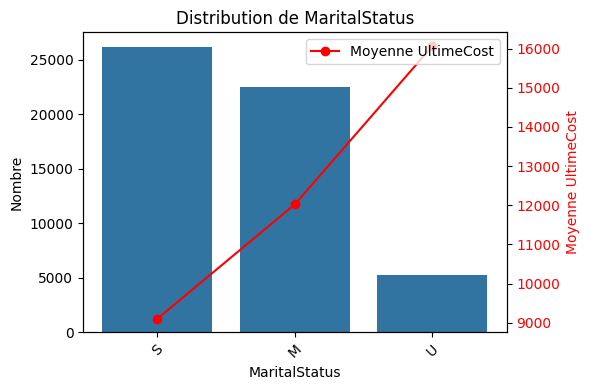

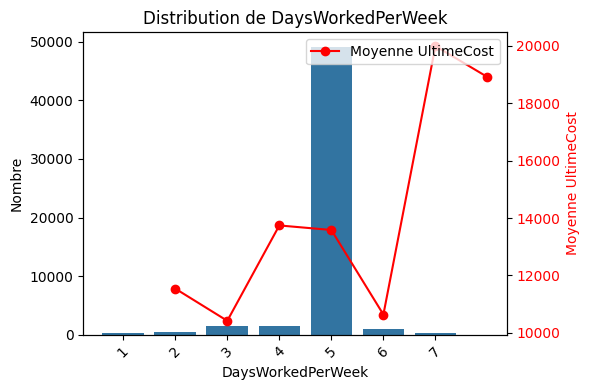

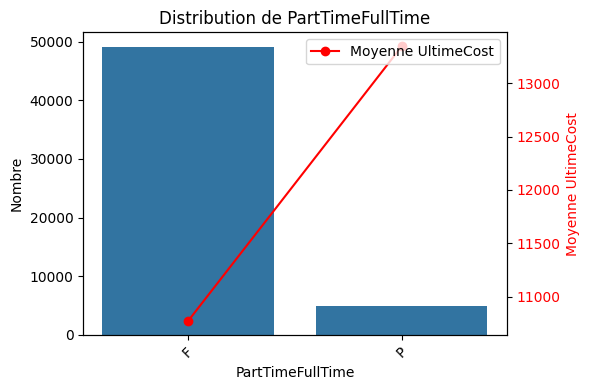

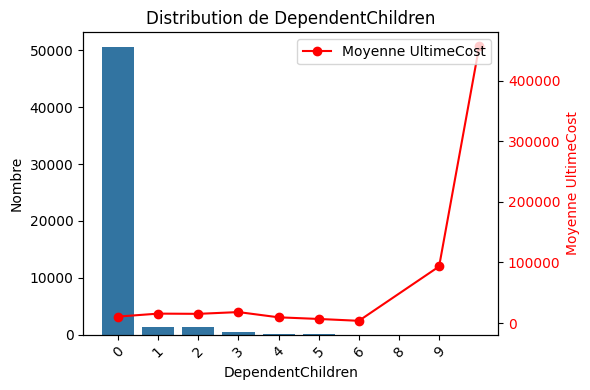

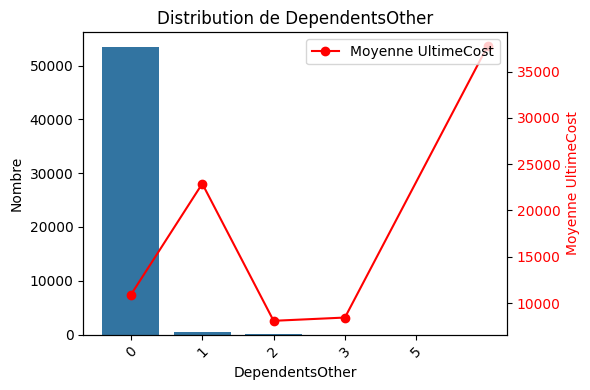

In [215]:
variables = ['Gender', 'MaritalStatus', 'DaysWorkedPerWeek', 
             'PartTimeFullTime', 'DependentChildren', 'DependentsOther']

for var in variables:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(df_train[var]):
        # Ordre numérique croissant
        order = sorted(df_train[var].dropna().unique())
    else:
        order = df_train[var].value_counts().index

    ax1 = sns.countplot(data=df_train, x=var, order=order)
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel('Nombre')
    plt.xticks(rotation=45)

    # Calcul de la moyenne
    grouped = df_train.groupby(var)['UltimateIncurredClaimCost'].mean().reindex(order)

    # Axe secondaire
    ax2 = ax1.twinx()
    ax2.plot(order, grouped.values, color='red', marker='o', linestyle='-', label='Moyenne UltimeCost')
    ax2.set_ylabel('Moyenne UltimeCost', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3465874985.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_stats = df_train.groupby(['AgeGroup', 'Gender'])['UltimateIncurredClaimCost'].agg(


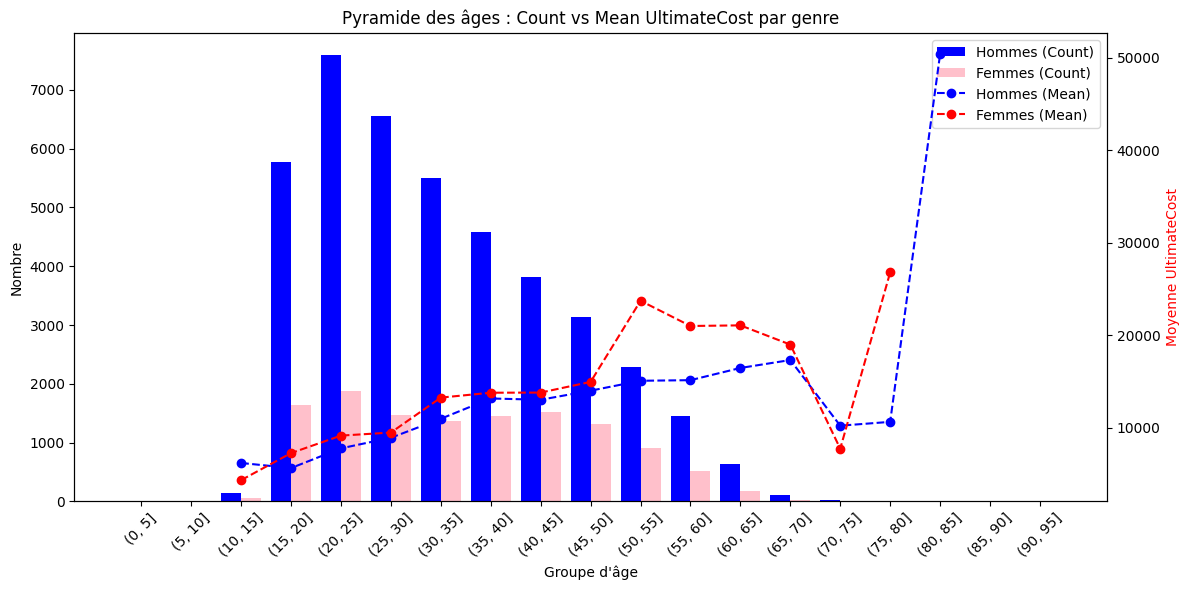

In [216]:
# On suppose que tu as déjà pivot_table
bins = list(range(0, 100, 5))
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins)

age_gender_stats = df_train.groupby(['AgeGroup', 'Gender'])['UltimateIncurredClaimCost'].agg(
    Count='count',
    MeanUltimate='mean'
).reset_index()

# On garde l'ordre des classes d'âge (en texte)
age_groups = age_gender_stats['AgeGroup'].unique().astype(str)

# Séparer les données par genre
male_data = age_gender_stats[age_gender_stats['Gender'] == 'M']
female_data = age_gender_stats[age_gender_stats['Gender'] == 'F']

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Axe 1 : Count (barres) ---
width = 0.4
x = np.arange(len(age_groups))

ax1.bar(x - width/2, male_data['Count'], width=width, label='Hommes (Count)', color='blue')
ax1.bar(x + width/2, female_data['Count'], width=width, label='Femmes (Count)', color='pink')

ax1.set_xlabel('Groupe d\'âge')
ax1.set_ylabel('Nombre')
ax1.set_xticks(x)
ax1.set_xticklabels(age_groups, rotation=45)

# --- Axe 2 : MeanUltimate (ligne) ---
ax2 = ax1.twinx()
ax2.plot(x, male_data['MeanUltimate'], color='blue', marker='o', linestyle='--', label='Hommes (Mean)')
ax2.plot(x, female_data['MeanUltimate'], color='red', marker='o', linestyle='--', label='Femmes (Mean)')
ax2.set_ylabel('Moyenne UltimateCost', color='red')

# --- Légendes ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Pyramide des âges : Count vs Mean UltimateCost par genre')
plt.tight_layout()
plt.show()


In [217]:
age_gender_stats = df_train.groupby(['AgeGroup', 'Gender'])['UltimateIncurredClaimCost'].agg(
    Count='count',
    MeanUltimate='mean'
).reset_index()

# Création du tableau croisé
pivot_table = age_gender_stats.pivot(index='AgeGroup', columns='Gender')

# Optionnel : renommer les colonnes (MultiIndex → noms simples)
pivot_table.columns = [f'{stat}_{gender}' for stat, gender in pivot_table.columns]

# Afficher le tableau croisé
pivot_table

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\3677669609.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_stats = df_train.groupby(['AgeGroup', 'Gender'])['UltimateIncurredClaimCost'].agg(


Count_F  Count_M  Count_U  MeanUltimate_F  MeanUltimate_M  \
AgeGroup                                                              
(0, 5]          0        0        0             NaN             NaN   
(5, 10]         0        0        0             NaN             NaN   
(10, 15]       52      149        0     4340.587081     6195.166200   
(15, 20]     1639     5769        0     7266.092230     5647.705819   
(20, 25]     1885     7590        0     9155.507696     7777.674162   
(25, 30]     1469     6555        0     9484.803042     8919.159788   
(30, 35]     1370     5506        0    13263.303092    10977.717563   
(35, 40]     1460     4589        1    13791.136479    13169.178008   
(40, 45]     1525     3819        0    13807.354746    13031.631376   
(45, 50]     1311     3144        1    14961.911946    14012.827561   
(50, 55]      904     2288        0    23731.851849    15083.910665   
(55, 60]      512     1460        0    21006.522317    15148.497278   
(60, 65]      176      643        0    21074.587610    16468.419160   
(65, 70]       28      114        0    18995.141100    17325.412853   
(70, 75]        3       28        0     7737.200560    10227.687509   
(75, 80]        4        5        0    26803.786307    10641.201064   
(80, 85]        0        1        0             NaN    50400.157680   
(85, 90]        0        0        0             NaN             NaN   
(90, 95]        0        0        0             NaN             NaN   

          MeanUltimate_U  
AgeGroup                  
(0, 5]               NaN  
(5, 10]              NaN  
(10, 15]             NaN  
(15, 20]             NaN  
(20, 25]             NaN  
(25, 30]             NaN  
(30, 35]             NaN  
(35, 40]     3175.049991  
(40, 45]             NaN  
(45, 50]     8997.635976  
(50, 55]             NaN  
(55, 60]             NaN  
(60, 65]             NaN  
(65, 70]             NaN  
(70, 75]             NaN  
(75, 80]             NaN  
(80, 85]             NaN  
(85, 90]             NaN  
(90, 95]             NaN

In [218]:
# Plusieurs facons metiers pour recoder la catégorie U ou Unknown, soit par nombre soit par montant => par montant
#df_train['Gender_flag'] = df_train['Gender'].map({'M': 0, 'F': 1, 'U' : 0})

# la classe U représente une classe minoritaire avec un la moyenne la plus élevé, on peut la mettre avec la classe M 
# vu qu'elles ont les moyenne les plus élevés
df_train['Gender_flag'] = df_train['Gender'].map({'M': 0, 'F': 1, 'U' : 0})
df_train['MaritalStatus_flag'] = df_train['MaritalStatus'].map({'S': 0, 'M': 1, 'U' : 1})
df_train['PartTimeFullTime_flag'] = df_train['PartTimeFullTime'].map({'F': 0, 'P': 1})

In [219]:
# on supprimes les variables pas importantes : dates, Dependent children, dependentsOther
df_train = df_train.drop(['DependentChildren', 'DependentsOther', 'mois_declaration', 'mois_sinistre' ], axis=1)
df_train

Age Gender MaritalStatus  WeeklyWages PartTimeFullTime  \
ClaimNumber                                                           
WC8285054     48      M             M       500.00                F   
WC6982224     43      F             M       509.34                F   
WC5481426     30      M             U       709.10                F   
WC9775968     41      M             S       555.46                F   
WC2634037     36      M             M       377.10                F   
...          ...    ...           ...          ...              ...   
WC9370727     32      F             S       500.00                F   
WC8396269     20      F             S       500.00                F   
WC3609528     19      M             S       283.00                F   
WC5038565     24      M             S       200.00                F   
WC2542601     22      M             S       200.00                F   

             HoursWorkedPerWeek  DaysWorkedPerWeek  \
ClaimNumber                                          
WC8285054                  38.0                  5   
WC6982224                  37.5                  5   
WC5481426                  38.0                  5   
WC9775968                  38.0                  5   
WC2634037                  38.0                  5   
...                         ...                ...   
WC9370727                  38.0                  5   
WC8396269                  40.0                  5   
WC3609528                  40.0                  5   
WC5038565                  38.0                  5   
WC2542601                  38.0                  5   

                                              ClaimDescription  \
ClaimNumber                                                      
WC8285054    LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY   
WC6982224    STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...   
WC5481426                     CUT ON SHARP EDGE CUT LEFT THUMB   
WC9775968                 DIGGING LOWER BACK LOWER BACK STRAIN   
WC2634037    REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...   
...                                                        ...   
WC9370727    STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...   
WC8396269     LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG   
WC3609528                METAL SLIPPED ACROSS METAL CUT FINGER   
WC5038565    BURN WHILST USING SPANNER LACERATION RIGHT MID...   
WC2542601    CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND...   

             InitialIncurredCalimsCost  UltimateIncurredClaimCost  \
ClaimNumber                                                         
WC8285054                         1500                4748.203388   
WC6982224                         5500                6326.285819   
WC5481426                         1700                2293.949087   
WC9775968                        15000               17786.487170   
WC2634037                         2800                4014.002925   
...                                ...                        ...   
WC9370727                         1000                 480.493308   
WC8396269                         1000                 755.735319   
WC3609528                          210                 418.178461   
WC5038565                         7500                2695.225700   
WC2542601                          550                 934.273548   

             annee_sinistre  annee_declaration  int_declar_jour  \
ClaimNumber                                                       
WC8285054              2002               2002               86   
WC6982224              1999               1999               12   
WC5481426              1996               1996               20   
WC9775968              2005               2005               29   
WC2634037              1990               1990               28   
...                     ...                ...              ...   
WC9370727              2004               2004               17   
WC8396269              200

In [220]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Age                           54000 non-null  int64   
 1   Gender                        54000 non-null  object  
 2   MaritalStatus                 54000 non-null  object  
 3   WeeklyWages                   54000 non-null  float64 
 4   PartTimeFullTime              54000 non-null  object  
 5   HoursWorkedPerWeek            54000 non-null  float64 
 6   DaysWorkedPerWeek             54000 non-null  int64   
 7   ClaimDescription              54000 non-null  object  
 8   InitialIncurredCalimsCost     54000 non-null  int64   
 9   UltimateIncurredClaimCost     54000 non-null  float64 
 10  annee_sinistre                54000 non-null  int32   
 11  annee_declaration             54000 non-null  int32   
 12  int_declar_jour               54000 non

### 2.iii. La variable à prédire : UltimateIncurredClaim Cost

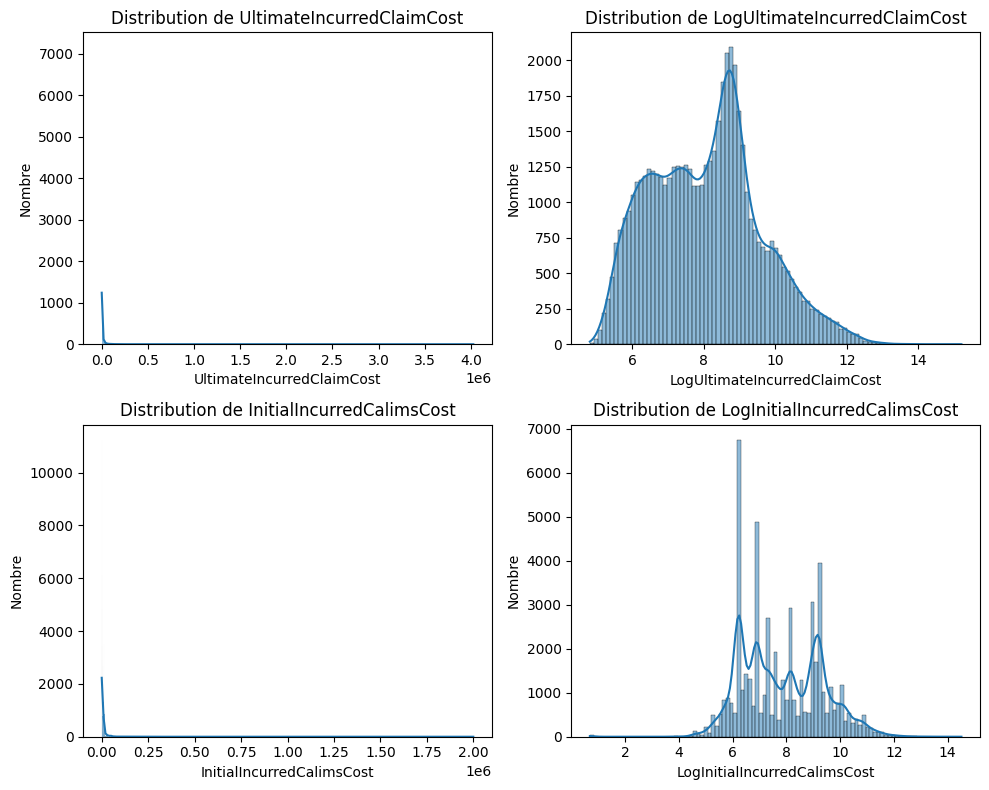

In [221]:
variables = ['UltimateIncurredClaimCost', 'LogUltimateIncurredClaimCost', 
             'InitialIncurredCalimsCost', 'LogInitialIncurredCalimsCost']
n_vars = len(variables)

n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(df_train[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Nombre')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


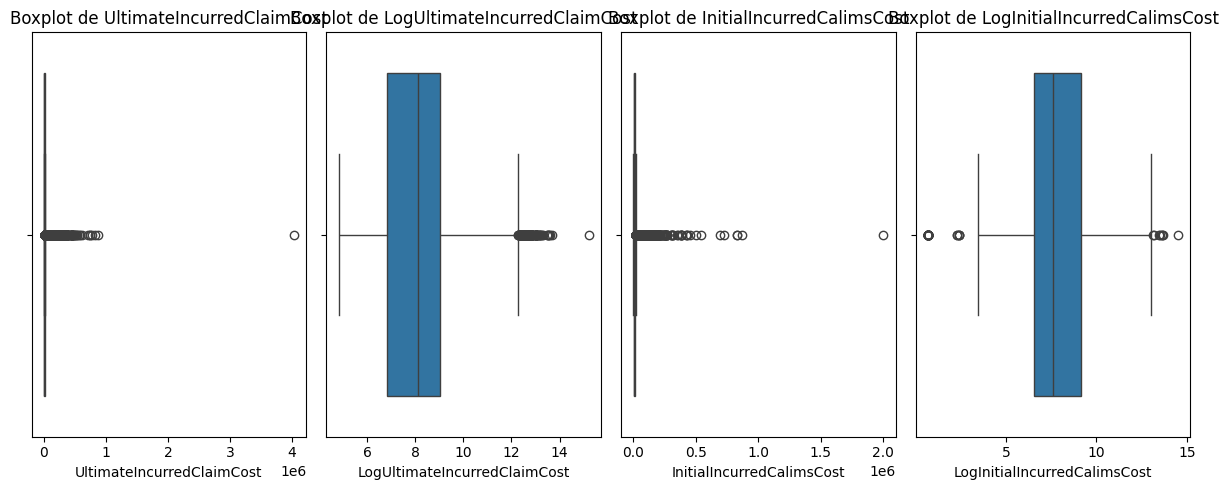

In [222]:
fig, axes = plt.subplots(1, len(variables), figsize=(12, 5))

for i, var in enumerate(variables):
    sns.boxplot(x=df_train[var], ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()

Le distribution des coûts ultime est très asymétrique, nous avons vu dans l'analyse descriptive basique que 
la moyenne est de 11003 avec des valeurs abérantes dépassant les 4M. 
La meilleure chose à faire est de transformer la variable avec un Log transfo. 

In [223]:
df_high_cost = df_train[df_train['UltimateIncurredClaimCost'] > 1000000]
df_high_cost

Age Gender MaritalStatus  WeeklyWages PartTimeFullTime  \
ClaimNumber                                                           
WC9916019     51      F             M        390.0                F   

             HoursWorkedPerWeek  DaysWorkedPerWeek  \
ClaimNumber                                          
WC9916019                  40.0                  5   

                                        ClaimDescription  \
ClaimNumber                                                
WC9916019    SLIPPED ON WET FLOOR FRACTURED BASE OF HAND   

             InitialIncurredCalimsCost  UltimateIncurredClaimCost  \
ClaimNumber                                                         
WC9916019                        43000                4027135.935   

             annee_sinistre  annee_declaration  int_declar_jour  \
ClaimNumber                                                       
WC9916019              2005               2006               27   

             int_declar_sem  HourWages  LogUltimateIncurredClaimCost  \
ClaimNumber                                                            
WC9916019                 3       9.75                     15.208566   

             LogInitialIncurredCalimsCost  AgeGroup  Gender_flag  \
ClaimNumber                                                        
WC9916019                       10.668979  (50, 55]            1   

             MaritalStatus_flag  PartTimeFullTime_flag  
ClaimNumber                                             
WC9916019                     1                      0

# Coût Initial vs coût Ultime ?

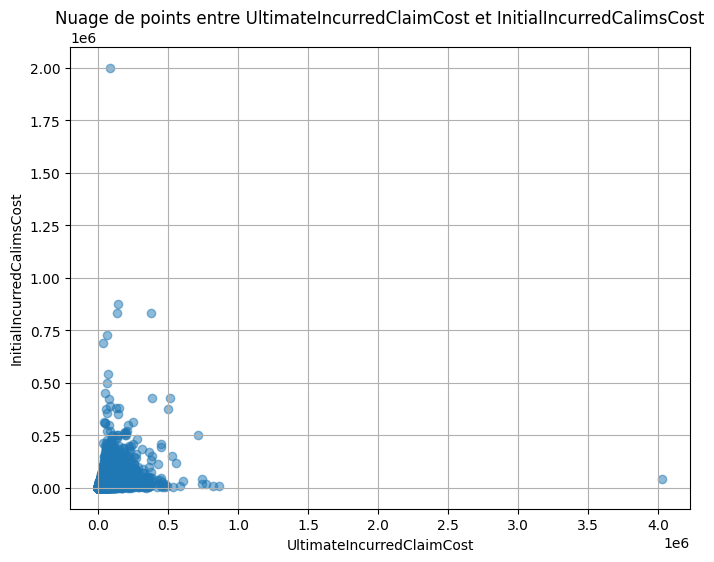

In [224]:
plt.figure(figsize=(8, 6))
plt.scatter(df_train['UltimateIncurredClaimCost'], df_train['InitialIncurredCalimsCost'], alpha=0.5)
plt.xlabel('UltimateIncurredClaimCost')
plt.ylabel('InitialIncurredCalimsCost')
plt.title('Nuage de points entre UltimateIncurredClaimCost et InitialIncurredCalimsCost')
plt.grid(True)
plt.show()

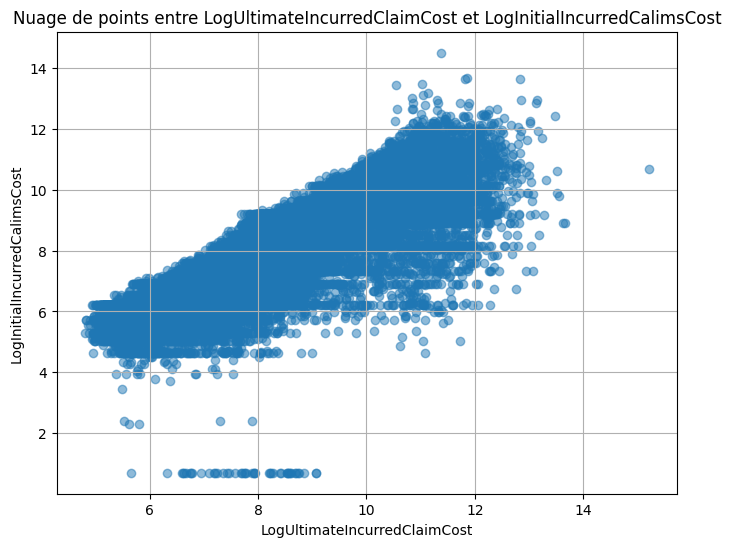

In [225]:
plt.figure(figsize=(8, 6))
plt.scatter(df_train['LogUltimateIncurredClaimCost'], df_train['LogInitialIncurredCalimsCost'], alpha=0.5)
plt.xlabel('LogUltimateIncurredClaimCost')
plt.ylabel('LogInitialIncurredCalimsCost')
plt.title('Nuage de points entre LogUltimateIncurredClaimCost et LogInitialIncurredCalimsCost')
plt.grid(True)
plt.show()

C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\2120220931.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.LogUltimateIncurredClaimCost, kde=True, label='Ultimate',bins=100)
C:\Users\rzahiri\AppData\Local\Temp\ipykernel_16092\2120220931.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

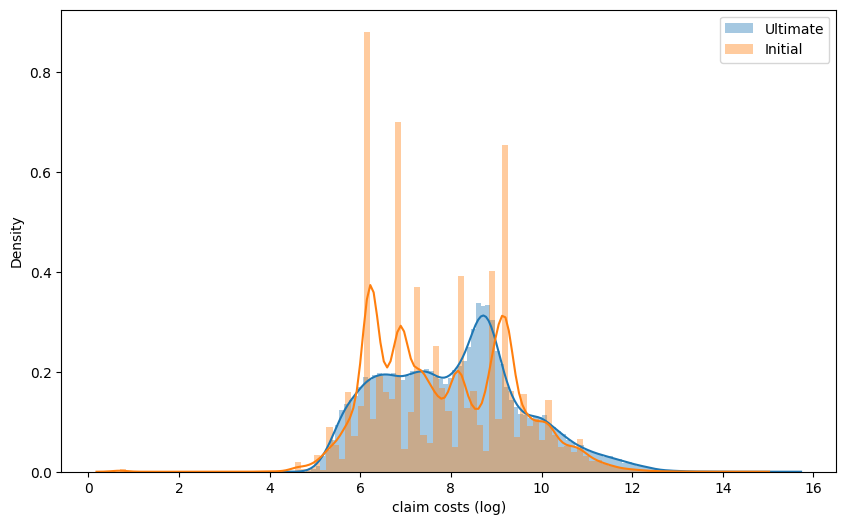

In [226]:
plt.subplots(figsize=(10, 6))
sns.distplot(df_train.LogUltimateIncurredClaimCost, kde=True, label='Ultimate',bins=100)
sns.distplot(df_train.LogInitialIncurredCalimsCost, kde=True, label='Initial', bins=100)
plt.xlabel('claim costs (log)')
plt.legend()
plt.show()

In [227]:
df_train['UltimateIncurredClaimCost'].groupby(df_train['InitialIncurredCalimsCost']).agg(['mean','median','min','count']).query('count >= 2000')

mean       median          min  count
InitialIncurredCalimsCost                                               
500                         1234.309657   514.491131   138.475198   6260
1000                        1984.477149   975.563918   289.452746   4587
1500                        4488.058672  2094.668686   614.644223   2329
3500                        9691.465926  5659.889398  1238.853926   2600
7500                       11128.475071  6137.809281  2222.464496   2507
10000                      11858.388278  7313.963420  2294.230002   3453

=> les coûts ultimes sont 2 à 3 fois supérieur  aux couts initaux

In [228]:
quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
rows = []

for annee in sorted(df_train["annee_declaration"].dropna().unique()):
    s = df_train.loc[df_train["annee_declaration"] == annee, "InitialIncurredCalimsCost"].dropna()
    q_values = [s.quantile(q) for q in quantiles]
    mean_ = s.mean()
    min_  = s.min()
    max_  = s.max()
    rows.append([annee] + q_values + [mean_, min_, max_])

col_names = (
    ["annee_declaration"] +
    [f"Q{int(q*100):02d}" for q in quantiles] +  # 05, 10, 25, ...
    ["mean", "min", "max"]
)

quantiles_df = pd.DataFrame(rows, columns=col_names)
quantiles_df


annee_declaration     Q05     Q10     Q25     Q50      Q75      Q90  \
0                1988   250.0   367.2   592.5  2000.0   3500.0   9000.0   
1                1989   250.0   327.6   500.0  1200.0   3500.0   6000.0   
2                1990   300.0   400.0   525.0  1280.5   3500.0   5310.0   
3                1991   315.0   420.0   510.0  1400.0   3500.0   6200.0   
4                1992   300.0   400.0   600.0  1634.0   3500.0   7500.0   
5                1993   325.0   500.0   650.0  2000.0   7500.0   9500.0   
6                1994   375.7   500.0   750.0  2200.0   7500.0  12600.0   
7                1995   200.0   264.0   500.0  1300.0   7500.0   7800.0   
8                1996   250.0   300.0   500.0  1320.0   7500.0  10000.0   
9                1997   250.0   300.0   500.0  1500.0   7500.0  11000.0   
10               1998   250.0   350.0   500.0  2000.0  10000.0  15000.0   
11               1999   500.0   500.0   500.0  2500.0  10000.0  18900.0   
12               2000   500.0   500.0   500.0  5000.0  10000.0  25000.0   
13               2001   500.0   500.0   500.0  7000.0  15000.0  26000.0   
14               2002   500.0  1000.0  1000.0  7000.0  15000.0  30000.0   
15               2003  1000.0  1000.0  1000.0  5000.0  15000.0  32500.0   
16               2004  1000.0  1000.0  1500.0  9500.0  20000.0  44854.8   
17               2005  1000.0  1000.0  1500.0  9500.0  20000.0  50000.0   
18               2006  1000.0  1000.0  1000.0  4250.0  22250.0  70495.0   

        Q95        Q99          mean  min      max  
0   10000.0   25000.00   3572.872563   42   315000  
1   10000.0   25610.00   3107.826788   70   156000  
2    8053.0   20123.00   2634.155743   10   121000  
3    9600.0   24000.00   3011.950515   10   156000  
4   11035.0   26157.00   3644.319509    9   377000  
5   14500.0   41000.00   4723.858401    1   127500  
6   20000.0   48729.00   5612.816096   50   125000  
7   12600.0   33444.00   4505.317163    1   725000  
8   15960.0   43440.00   4917.698580  100   260896  
9   20000.0   45000.00   5401.509434   60   250297  
10  25000.0   50000.00   6878.868603   90   500000  
11  25000.0   50000.00   7478.100962   50   227000  
12  35000.0   82770.00  10088.968280  150   690000  
13  45000.0  106470.00  12309.422018    1   450000  
14  50000.0  100100.00  13029.651397    1   425000  
15  50000.0   95000.00  13034.499327    1   540000  
16  62694.5  131304.61  17276.332024    1  2000000  
17  70495.0  128792.20  18045.573272    1   872980  
18  91750.0  155271.26  20139.995868  100   202000

=> les coûts augmentent avec les années de sinitres : effet inflation?

 # Données déséquilibrées?

In [229]:
int_cols = df_train.select_dtypes(include=['int', 'int32', 'int64', 'float64']).columns

skew_values = df_train[int_cols].skew()

print(skew_values)

Age                              0.536341
WeeklyWages                      4.122767
HoursWorkedPerWeek              24.132974
DaysWorkedPerWeek               -3.340468
InitialIncurredCalimsCost       26.853657
UltimateIncurredClaimCost       37.552504
annee_sinistre                  -0.002754
annee_declaration               -0.007551
int_declar_jour                  6.594077
int_declar_sem                   6.582577
HourWages                       13.258067
LogUltimateIncurredClaimCost     0.286833
LogInitialIncurredCalimsCost     0.214053
Gender_flag                      1.293430
MaritalStatus_flag              -0.060029
PartTimeFullTime_flag            2.854373
dtype: float64


In [230]:
#one hot coded dichotom
df_train = pd.get_dummies(df_train, columns=['MaritalStatus_flag'], prefix=['Marital'], drop_first=False, dtype=int)
df_train = pd.get_dummies(df_train, columns=['Gender_flag'], prefix=['Gender'], drop_first=False, dtype=int)
df_train = pd.get_dummies(df_train, columns=['PartTimeFullTime_flag'], prefix=['PartTimeFullTime'], drop_first=False, dtype=int)
df_train.head(5)

Age Gender MaritalStatus  WeeklyWages PartTimeFullTime  \
ClaimNumber                                                           
WC8285054     48      M             M       500.00                F   
WC6982224     43      F             M       509.34                F   
WC5481426     30      M             U       709.10                F   
WC9775968     41      M             S       555.46                F   
WC2634037     36      M             M       377.10                F   

             HoursWorkedPerWeek  DaysWorkedPerWeek  \
ClaimNumber                                          
WC8285054                  38.0                  5   
WC6982224                  37.5                  5   
WC5481426                  38.0                  5   
WC9775968                  38.0                  5   
WC2634037                  38.0                  5   

                                              ClaimDescription  \
ClaimNumber                                                      
WC8285054    LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY   
WC6982224    STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...   
WC5481426                     CUT ON SHARP EDGE CUT LEFT THUMB   
WC9775968                 DIGGING LOWER BACK LOWER BACK STRAIN   
WC2634037    REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...   

             InitialIncurredCalimsCost  UltimateIncurredClaimCost  \
ClaimNumber                                                         
WC8285054                         1500                4748.203388   
WC6982224                         5500                6326.285819   
WC5481426                         1700                2293.949087   
WC9775968                        15000               17786.487170   
WC2634037                         2800                4014.002925   

             annee_sinistre  annee_declaration  int_declar_jour  \
ClaimNumber                                                       
WC8285054              2002               2002               86   
WC6982224              1999               1999               12   
WC5481426              1996               1996               20   
WC9775968              2005               2005               29   
WC2634037              1990               1990               28   

             int_declar_sem  HourWages  LogUltimateIncurredClaimCost  \
ClaimNumber                                                            
WC8285054                12  13.157895                      8.465732   
WC6982224                 1  13.582400                      8.752627   
WC5481426                 2  18.660526                      7.738466   
WC9775968                 4  14.617368                      9.786251   
WC2634037                 4   9.923684                      8.297793   

             LogInitialIncurredCalimsCost  AgeGroup  Marital_0  Marital_1  \
ClaimNumber                                                                 
WC8285054                        7.313887  (45, 50]          0          1   
WC6982224                        8.612685  (40, 45]          0          1   
WC5481426                        7.438972  (25, 30]          0          1   
WC9775968                        9.615872  (40, 45]          1          0   
WC2634037                        7.937732  (35, 40]          0          1   

             Gender_0  Gender_1  PartTimeFullTime_0  PartTimeFullTime_1  
ClaimNumber                                                              
WC8285054           1         0                   1                   0  
WC6982224           0         1                   1                   0  
WC5481426           1         0                   1                   0  
WC9775968           1         0                   1                   0  
WC2634037           1         0                   1                   0

#### 2.iv. Analyse sémantique de la description du sinistre :

In [231]:
# Claim description
df_claims_desc = df_train[['ClaimDescription', 'InitialIncurredCalimsCost', 'UltimateIncurredClaimCost']]
df_claims_desc.sort_values(by="UltimateIncurredClaimCost", ascending=False)

ClaimDescription  \
ClaimNumber                                                      
WC9916019          SLIPPED ON WET FLOOR FRACTURED BASE OF HAND   
WC4540054    WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY ...   
WC2854573      TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND   
WC8981820                             LIFTING BACK BACK STRAIN   
WC9097605               SHEARING HAND PIECE BLISTER RIGHT HAND   
...                                                        ...   
WC5774305    PARTICLE IN EYE WHILE GRINDING FOREIGN BODY RI...   
WC5151318              FOREIGN BODY RUST FOREIGN BODY LEFT EYE   
WC5754495                 GLASS INTO EYE FOREIGN BODY LEFT EYE   
WC5312022           PARTICLE FROM DRILL FOREIGN BODY RIGHT EYE   
WC5578892    FOREIGN BODY METAL FRAGMENT LEFT CORNEAL FOREI...   

             InitialIncurredCalimsCost  UltimateIncurredClaimCost  
ClaimNumber                                                        
WC9916019                        43000               4.027136e+06  
WC4540054                         7500               8.657706e+05  
WC2854573                         7500               8.237063e+05  
WC8981820                        17880               7.684851e+05  
WC9097605                        40456               7.420032e+05  
...                                ...                        ...  
WC5774305                          200               1.314570e+02  
WC5151318                          260               1.291061e+02  
WC5754495                          300               1.245797e+02  
WC5312022                          300               1.231649e+02  
WC5578892                          200               1.218868e+02  

[54000 rows x 3 columns]

('right', 'left', 'back', 'strain', 'lower', 'and', 'finger', 'lifting', 'hand', 'struck', 'shoulder', 'fell', 'slipped', 'laceration', 'eye', 'knee', 'lacerated', 'on', 'injury', 'strained', 'foreign', 'body', 'wrist', 'thumb', 'neck', 'bruised', 'cut', 'ankle', 'hit', 'knife')


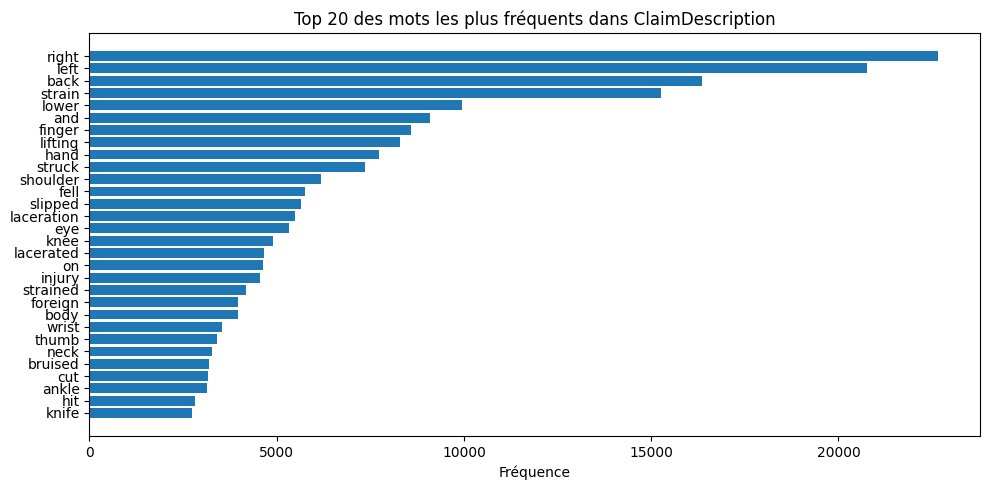

In [232]:
# Nettoyage + extraction des mots
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    words = text.split() 
    return words

# Appliquer à toutes les descriptions
all_words = []
for desc in df_claims_desc['ClaimDescription']:
    all_words.extend(clean_text(desc))


# Compter les mots
word_counts = Counter(all_words)

# Afficher les N mots les plus fréquents
top_words = word_counts.most_common(30)

# Affichage
words, counts = zip(*top_words)
print(words)
plt.figure(figsize=(10, 5))
plt.barh(words[::-1], counts[::-1])  # horizontal bar plot (plus lisible)
plt.title("Top 20 des mots les plus fréquents dans ClaimDescription")
plt.xlabel("Fréquence")
plt.tight_layout()
plt.show()


In [233]:
body_parts = [
    'unknown','hand', 'finger', 'back', 'wrist', 'arm', 'shoulder', 'thumb', 'leg', 'chin', 'stomach', 'forearm', 'eye']

causes = [
    'cut', 'slip', 'fall', 'lift', 'strain', 'burn', 'lacerate', 'fracture', 'dig', 'reach', 'unknown'
]

def extract_info(description):
    desc = description.lower()

    # Cherche le body part
    found_parts = [bp for bp in body_parts if bp in desc]
    body_part = ', '.join(found_parts) if found_parts else 'unknown'

    # Cherche la cause
    found_causes = [c for c in causes if c in desc]
    cause = ', '.join(found_causes) if found_causes else 'unknown'

    return {'body_part': body_part, 'cause': cause}

# Appliquer à chaque ligne
claim_dict = df_claims_desc['ClaimDescription'].apply(extract_info).to_dict()
claim_dict = pd.DataFrame(claim_dict)

claim_dict=claim_dict.T

In [234]:
for part in body_parts:
    claim_dict[f'body_{part}'] = claim_dict['body_part'].str.contains(part).astype(int)
    
for c in causes:
    claim_dict[f'cause_{c}'] = claim_dict['cause'].str.contains(c).astype(int)

In [235]:
claim_dict['n_body_parts'] = claim_dict['body_part'].str.count(',') + 1
claim_dict['n_causes'] = claim_dict['cause'].str.count(',') + 1
claim_dict

body_part               cause  body_hand  \
WC8285054               wrist, arm                lift          0   
WC6982224             arm, forearm            fracture          0   
WC5481426                    thumb                 cut          0   
WC9775968                     back         strain, dig          0   
WC2634037  shoulder, chin, stomach  cut, strain, reach          0   
...                            ...                 ...        ...   
WC9370727             hand, finger            lacerate          1   
WC8396269          hand, back, leg             unknown          1   
WC3609528                   finger           cut, slip          0   
WC5038565                   finger                burn          0   
WC2542601                   finger                 cut          0   

           body_finger  body_back  body_wrist  body_arm  body_shoulder  \
WC8285054            0          0           1         1              0   
WC6982224            0          0           0         1              0   
WC5481426            0          0           0         0              0   
WC9775968            0          1           0         0              0   
WC2634037            0          0           0         0              1   
...                ...        ...         ...       ...            ...   
WC9370727            1          0           0         0              0   
WC8396269            0          1           0         0              0   
WC3609528            1          0           0         0              0   
WC5038565            1          0           0         0              0   
WC2542601            1          0           0         0              0   

           body_thumb  body_leg  body_chin  body_stomach  body_forearm  \
WC8285054           0         0          0             0             0   
WC6982224           0         0          0             0             1   
WC5481426           1         0          0             0             0   
WC9775968           0         0          0             0             0   
WC2634037           0         0          1             1             0   
...               ...       ...        ...           ...           ...   
WC9370727           0         0          0             0             0   
WC8396269           0         1          0             0             0   
WC3609528           0         0          0             0             0   
WC5038565           0         0          0             0             0   
WC2542601           0         0          0             0             0   

           body_eye  cause_cut  cause_slip  cause_fall  cause_lift  \
WC8285054         0          0           0           0           1   
WC6982224         0          0           0           0           0   
WC5481426         0          1           0           0           0   
WC9775968         0          0           0           0           0   
WC2634037         0          1           0           0           0   
...             ...        ...         ...         ...         ...   
WC9370727         0          0           0           0           0   
WC8396269         0          0           0           0           0   
WC3609528         0          1           1           0           0   
WC5038565         0          0           0           0           0   
WC2542601         0          1           0           0           0   

           cause_strain  cause_burn  cause_lacerate  cause_fracture  \
WC8285054             0           0               0               0   
WC6982224             0           0               0               1   
WC5481426             0           0               0               0   
WC9775968             1           0               0               0   
WC2634037             1           0               0               0   
...                 ...         ...             ...             ...   
WC9370727             0           0               1               0   
WC8396269

In [236]:
df_concat = pd.concat([df_train, claim_dict], axis=1)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df_concat

Age Gender MaritalStatus  WeeklyWages PartTimeFullTime  \
WC8285054   48      M             M       500.00                F   
WC6982224   43      F             M       509.34                F   
WC5481426   30      M             U       709.10                F   
WC9775968   41      M             S       555.46                F   
WC2634037   36      M             M       377.10                F   
...        ...    ...           ...          ...              ...   
WC9370727   32      F             S       500.00                F   
WC8396269   20      F             S       500.00                F   
WC3609528   19      M             S       283.00                F   
WC5038565   24      M             S       200.00                F   
WC2542601   22      M             S       200.00                F   

           HoursWorkedPerWeek  DaysWorkedPerWeek  \
WC8285054                38.0                  5   
WC6982224                37.5                  5   
WC5481426                38.0                  5   
WC9775968                38.0                  5   
WC2634037                38.0                  5   
...                       ...                ...   
WC9370727                38.0                  5   
WC8396269                40.0                  5   
WC3609528                40.0                  5   
WC5038565                38.0                  5   
WC2542601                38.0                  5   

                                            ClaimDescription  \
WC8285054  LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY   
WC6982224  STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...   
WC5481426                   CUT ON SHARP EDGE CUT LEFT THUMB   
WC9775968               DIGGING LOWER BACK LOWER BACK STRAIN   
WC2634037  REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...   
...                                                      ...   
WC9370727  STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...   
WC8396269   LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG   
WC3609528              METAL SLIPPED ACROSS METAL CUT FINGER   
WC5038565  BURN WHILST USING SPANNER LACERATION RIGHT MID...   
WC2542601  CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND...   

           InitialIncurredCalimsCost  UltimateIncurredClaimCost  \
WC8285054                       1500                4748.203388   
WC6982224                       5500                6326.285819   
WC5481426                       1700                2293.949087   
WC9775968                      15000               17786.487170   
WC2634037                       2800                4014.002925   
...                              ...                        ...   
WC9370727                       1000                 480.493308   
WC8396269                       1000                 755.735319   
WC3609528                        210                 418.178461   
WC5038565                       7500                2695.225700   
WC2542601                        550                 934.273548   

           annee_sinistre  annee_declaration  int_declar_jour  int_declar_sem  \
WC8285054            2002               2002               86              12   
WC6982224            1999               1999               12               1   
WC5481426            1996               1996               20               2   
WC9775968            2005               2005               29               4   
WC2634037            1990               1990               28               4   
...                   ...                ...              ...             ...   
WC9370727            2004               2004               17               2   
WC8396269            2002               2002              127              18   
WC3609528            1992               1992               18               2   
WC5038565            1995               1995               20               2   
WC2542601            1990               1990                9               1   

          

J'ai crée deux variables comme le nombre de causes de sinistre et le nombre de parties du corps touchées. 
à voir si elles sont significatives par rapport à la variables à prédire.

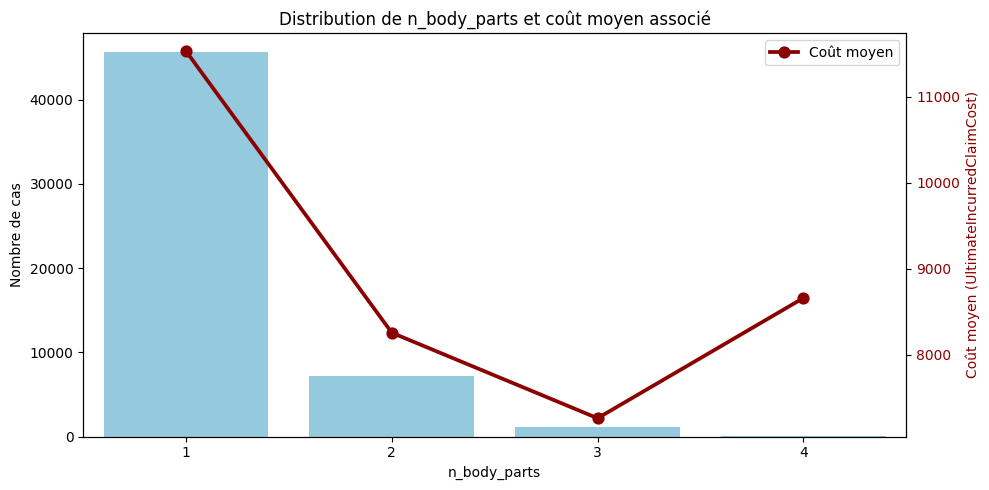

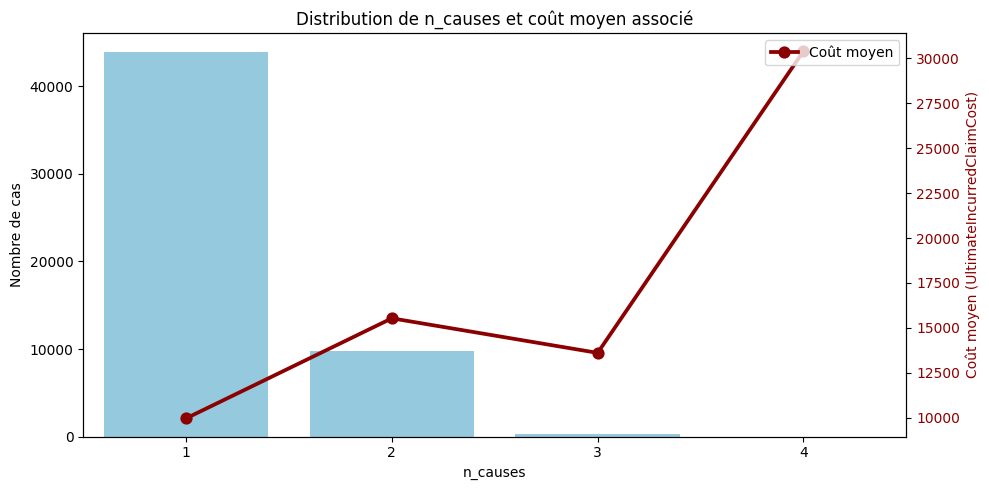

In [237]:
variables = ['n_body_parts', 'n_causes']

for var in variables:
    plt.figure(figsize=(10, 5))

    # Axe principal : nombre de cas (countplot)
    ax1 = sns.countplot(data=df_concat, x=var, order=df_concat[var].value_counts().index, color='skyblue')
    ax1.set_ylabel('Nombre de cas')
    ax1.set_xlabel(var)
    ax1.set_title(f"Distribution de {var} et coût moyen associé")

    # Créer second axe Y pour le coût moyen
    ax2 = ax1.twinx()

    # Calcul du coût moyen par catégorie
    grouped = df_concat.groupby(var)['UltimateIncurredClaimCost'].mean()
    grouped = grouped.reindex(df_concat[var].value_counts().index)  # Aligner l'ordre

    # Axe secondaire : barplot du coût moyen
    sns.pointplot(x=grouped.index, y=grouped.values, ax=ax2, color='darkred', markers='o', linestyles='-', label='Coût moyen')
    ax2.set_ylabel('Coût moyen (UltimateIncurredClaimCost)', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')

    # Rotation et mise en forme
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# 3 - Modélisation des coûts ultimes à l'aide de l'algorithme de XGBOOST

In [238]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Age                           54000 non-null  int64   
 1   Gender                        54000 non-null  object  
 2   MaritalStatus                 54000 non-null  object  
 3   WeeklyWages                   54000 non-null  float64 
 4   PartTimeFullTime              54000 non-null  object  
 5   HoursWorkedPerWeek            54000 non-null  float64 
 6   DaysWorkedPerWeek             54000 non-null  int64   
 7   ClaimDescription              54000 non-null  object  
 8   InitialIncurredCalimsCost     54000 non-null  int64   
 9   UltimateIncurredClaimCost     54000 non-null  float64 
 10  annee_sinistre                54000 non-null  int32   
 11  annee_declaration             54000 non-null  int32   
 12  int_declar_jour               54000 non

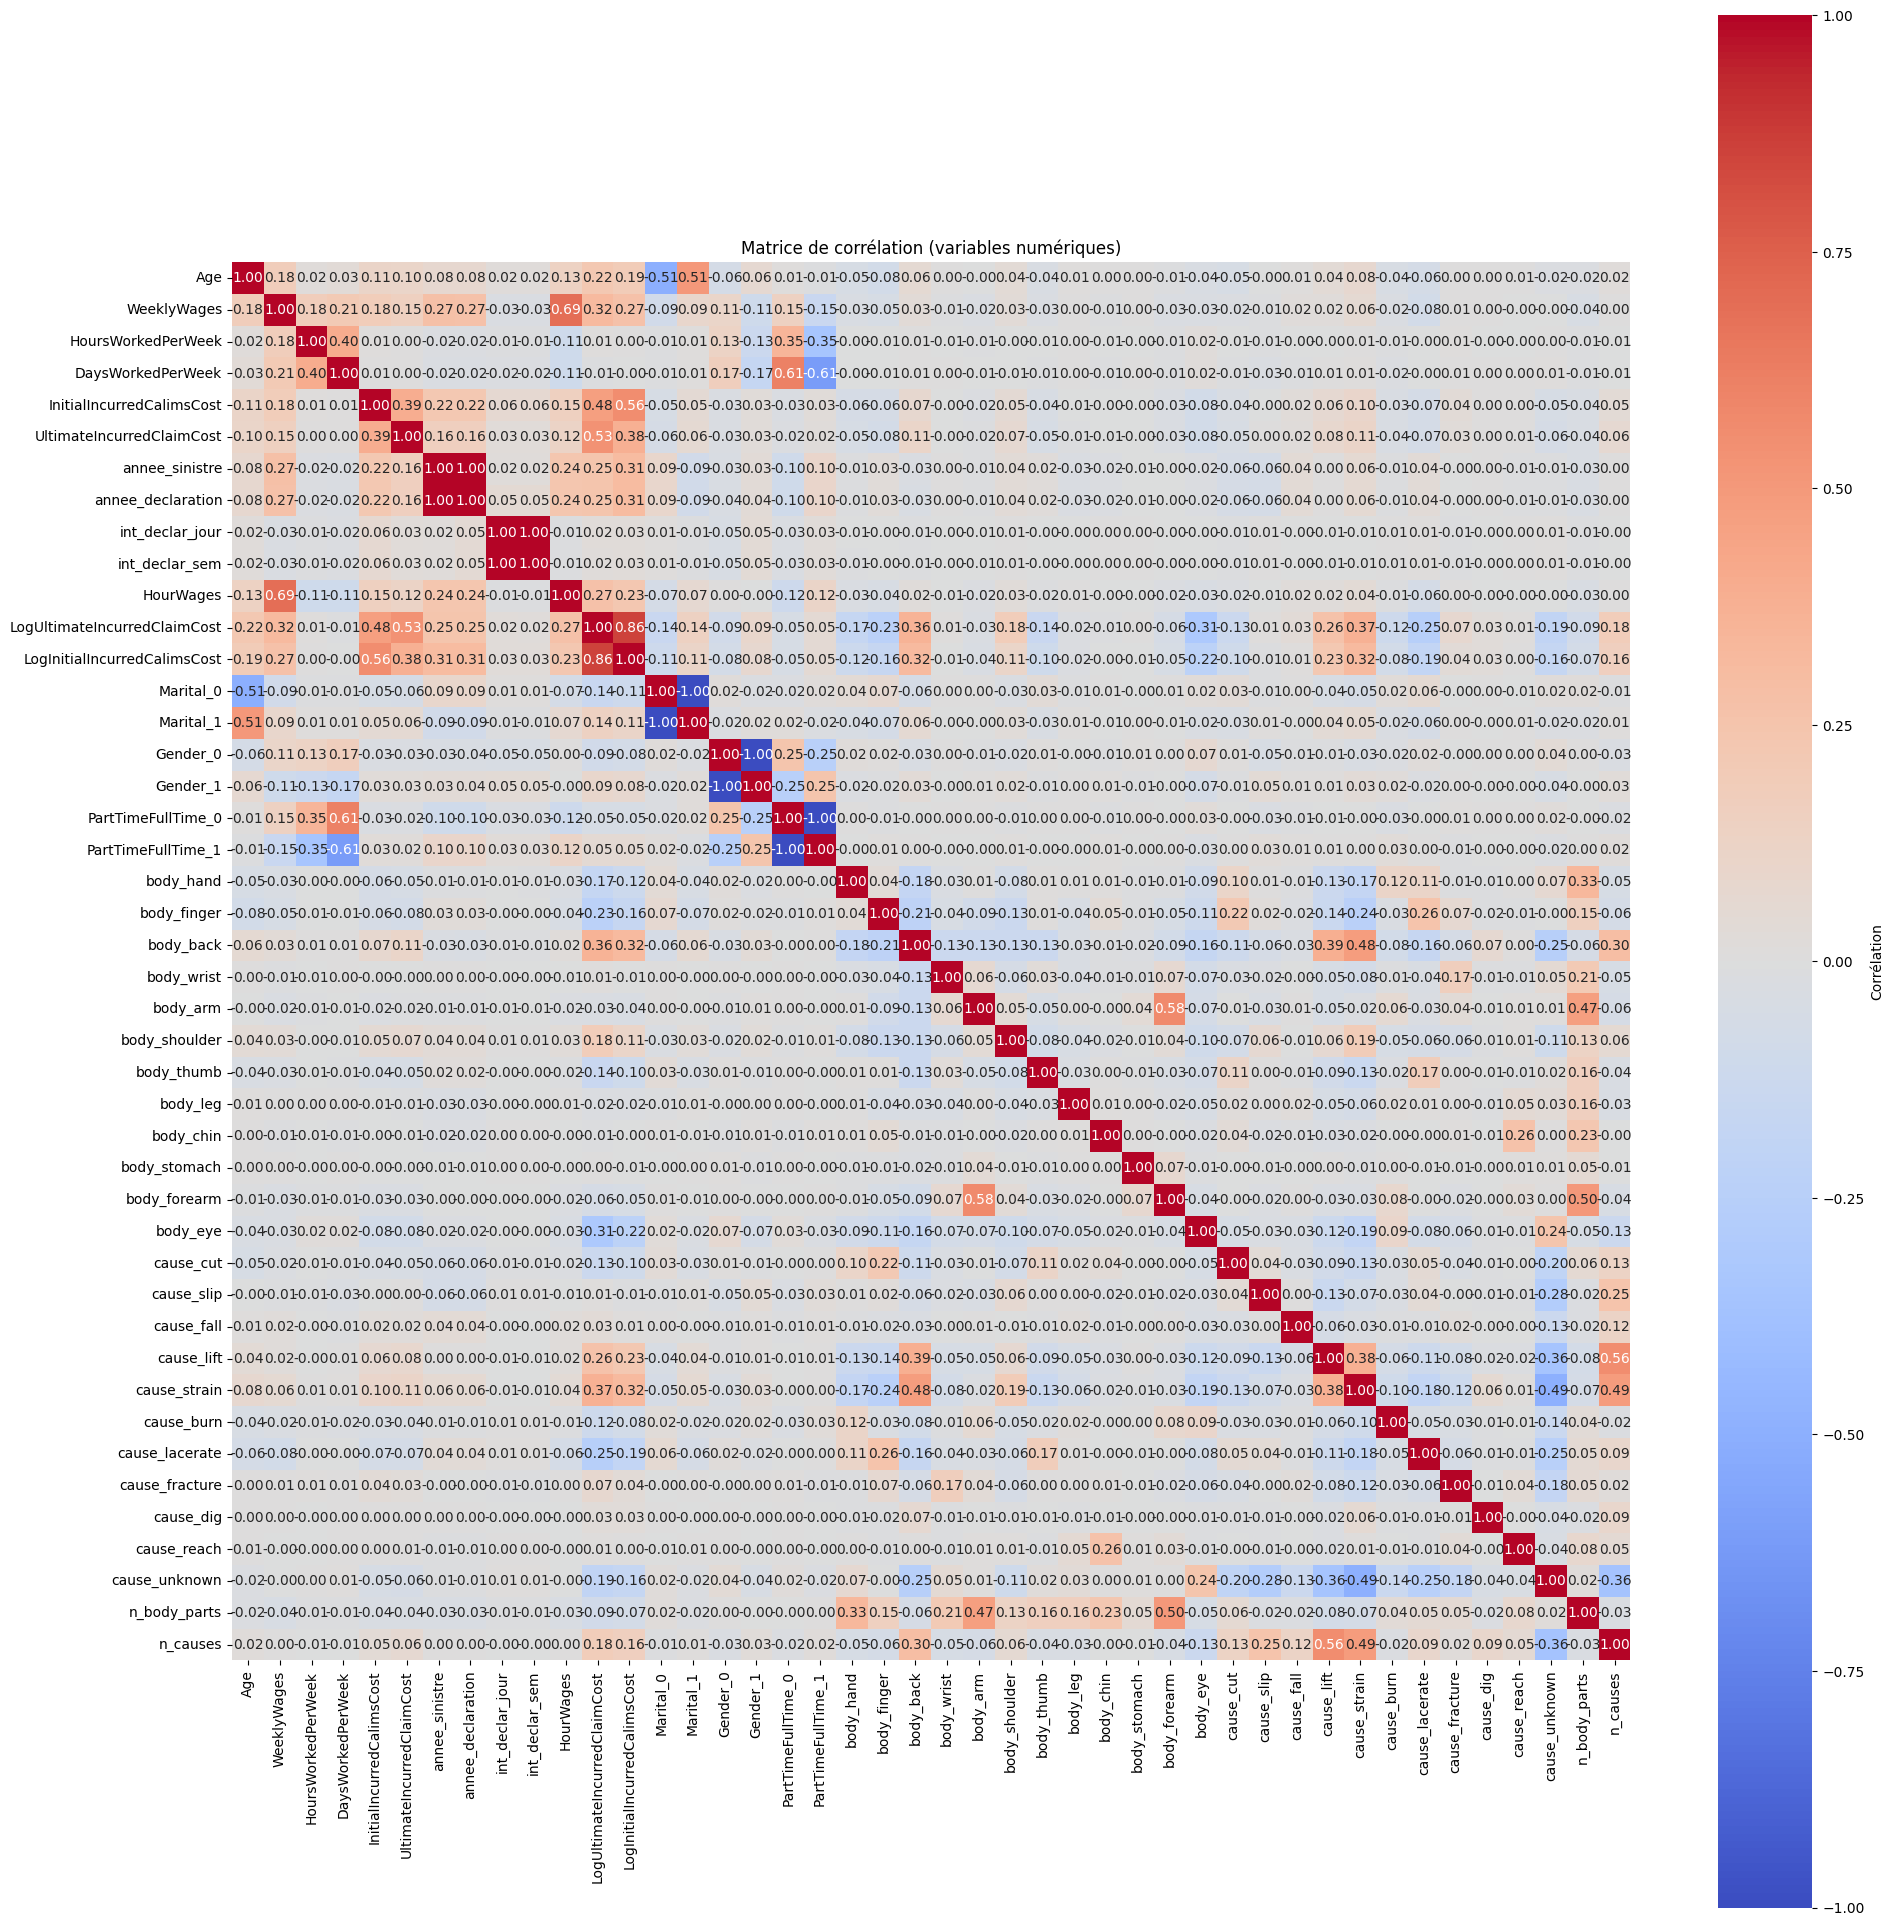

In [239]:
numeric_df = df_concat.select_dtypes(include='number')
corrmat = numeric_df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'Corrélation'})
plt.title("Matrice de corrélation (variables numériques)")
plt.tight_layout()
plt.show()

Les variables Log Initial et Ultime sont très corrélées entre elles, à prendre en considération afin de tester par la suite
le sur-apprentissage du modèle sur la base train.

In [240]:
df_concat['hours_day'] = df_concat['HoursWorkedPerWeek'] / df_concat['DaysWorkedPerWeek']

In [241]:
df_vf = df_concat.drop(['PartTimeFullTime', 'int_declar_sem', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost', 'WeeklyWages', 'annee_sinistre', 'annee_declaration', 'HoursWorkedPerWeek',
       'DaysWorkedPerWeek', 'AgeGroup', 'Gender',  'MaritalStatus', 'Gender_0', 'Gender_1'], axis=1)

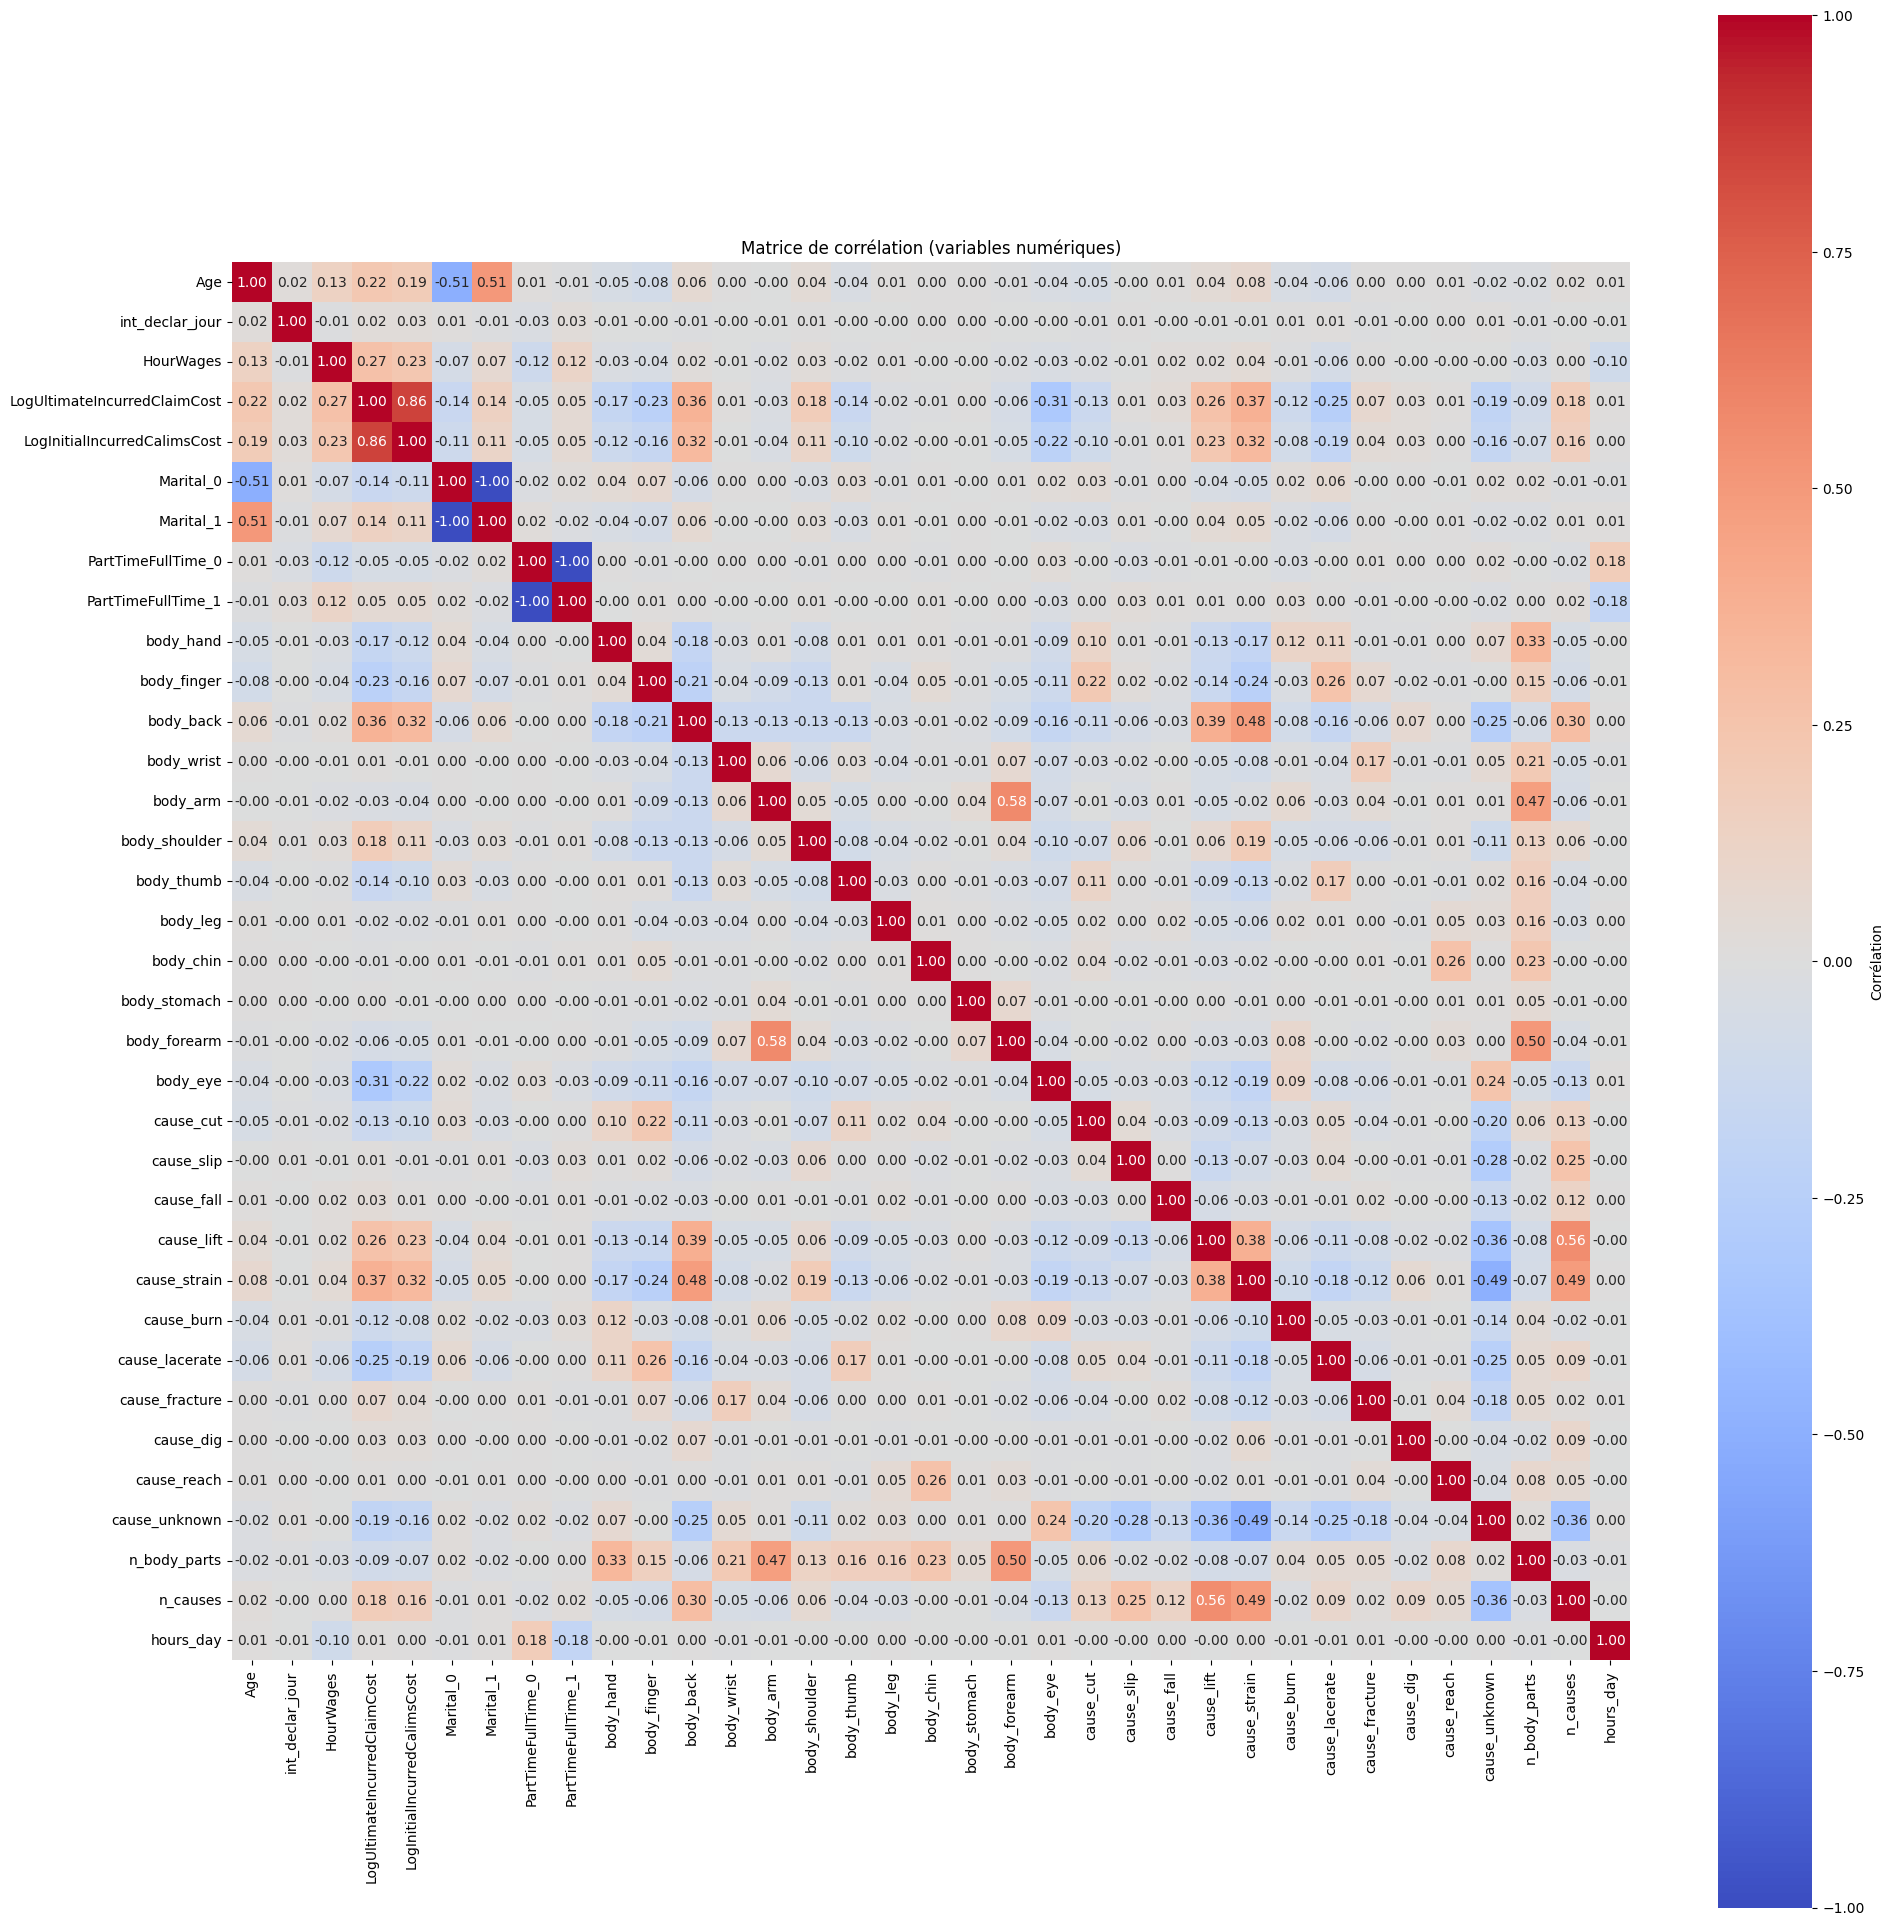

In [242]:
numeric_df = df_vf.select_dtypes(include='number')
corrmat = numeric_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'Corrélation'})
plt.title("Matrice de corrélation (variables numériques)")
plt.tight_layout()
plt.show()

In [243]:
df_vf.isnull().sum()

Age                              0
ClaimDescription                 0
int_declar_jour                  0
HourWages                       29
LogUltimateIncurredClaimCost     0
LogInitialIncurredCalimsCost     0
Marital_0                        0
Marital_1                        0
PartTimeFullTime_0               0
PartTimeFullTime_1               0
body_part                        0
cause                            0
body_hand                        0
body_finger                      0
body_back                        0
body_wrist                       0
body_arm                         0
body_shoulder                    0
body_thumb                       0
body_leg                         0
body_chin                        0
body_stomach                     0
body_forearm                     0
body_eye                         0
cause_cut                        0
cause_slip                       0
cause_fall                       0
cause_lift                       0
cause_strain        

In [244]:
df_nan_hourwages = df_vf[df_vf['HourWages'].isna()]
df_nan_hourwages

Age                                   ClaimDescription  \
WC4502082   32           PUSHING TROLLEY STRAIN LOWER BACK INJURY   
WC8035020   22  ARM CAUGHT UNDER STRAPPER LACERATION TO LEFT I...   
WC8944565   32                 PLAYING FOOTBALL RIGHT KNEE STRAIN   
WC5382920   25       LIFTING CRATE OF MILK BACK STRAIN LOWER BACK   
WC9539701   20          STRUCK KNIFE LACERATION RIGHT RING FINGER   
WC4300869   54                BACK INJURY MUSCLE STRAIN LEFT KNEE   
WC2616050   58          KNOCKED FORKLIFT STRAINED LOWER BACK PAIN   
WC4629293   42   SLIPPED WET FLOOR SOFT TISSUE INJURY LEFT FINGER   
WC9201927   39          FELL FROM TRUCK STEP BRUISING RIGHT ELBOW   
WC9169196   32       SPARK FROM CUT OFF MACHINE STRAIN LOWER BACK   
WC4508016   59  FELL TRIPPED ON FORKLIFT STRAINED LOWER BACK PAIN   
WC4835490   32           LIFTING CABINET ONTO TRUCK STRAINED BACK   
WC4481227   32      MOTOR VEHICLE ACCIDENT CAR RAN INTO BACK NECK   
WC4442559   32  FELL BACKWARDS LANDED ON HAND CRUSH INJURY RIG...   
WC4641823   53  LIFTING HEAVY BOX ON THE ROOF LACERATION RIGHT...   
WC3601745   23                   STRUCK WOODEN PALLET NECK STRAIN   
WC9617117   22           STRUCK HAND DRILL LACERATION RIGHT THUMB   
WC2446443   43                       LIFTING STEEL HERNIA ABDOMIN   
WC5986892   16  STRUCK WITH KNIFE LACERATED LEFT INDEX FINGER ...   
WC3787069   29                     LIFTING CRATE SOFT TISSUE NECK   
WC4823337   43  INJURY WHILE HELPING PATIENT STRAINED THORACIC...   
WC8944368   52              FOREIGN BODY DUST FOREIGN BODY IN EYE   
WC5298558   45  REPETITIVE COMPUTER USE RIGHT WRIST STRAIN BOT...   
WC4839221   47               LIFTING GYPROCK OFF TRUCK LOWER BACK   
WC8620559   33         MACHINE CAUGHT FINGER DRILL BRUISED FINGER   
WC7682643   22                CAUGHT ON PALLET SPRAIN RIGHT ANKLE   
WC4127407   50    SPILLED HOT WATER BURN LOWER LEFT LEG AND ANKLE   
WC4475221   32         FELL DOWN OFF CONVEYOR BELT RIGHT SHOULDER   
WC9796833   21                         HIT SPANNER RIGHT SHOULDER   

           int_declar_jour  HourWages  LogUltimateIncurredClaimCost  \
WC4502082               16        NaN                      9.246843   
WC8035020                1        NaN                      8.329516   
WC8944565               17        NaN                      8.233571   
WC5382920               16        NaN                      9.011690   
WC9539701               11        NaN                      8.889785   
WC4300869               14        NaN                      8.310622   
WC2616050                8        NaN                      8.807984   
WC4629293               13        NaN                      9.177391   
WC9201927               28        NaN                     12.261936   
WC9169196               34        NaN                      8.062078   
WC4508016               11        NaN                      8.823583   
WC4835490               24        NaN                      9.474301   
WC4481227               50        NaN                      9.641153   
WC4442559               16        NaN                      8.325308   
WC4641823                8        NaN                      8.545886   
WC3601745                8        NaN                      7.468457   
WC9617117               16        NaN                      8.468214   
WC2446443               45        NaN                      8.576367   
WC5986892               33        NaN                      6.094168   
WC3787069               19        NaN                      8.500917   
WC4823337                7        NaN                      9.021793   
WC8944368               90        NaN                      6.493512   
WC5298558                9        NaN                      8.061784   
WC4839221               10        NaN                      8.737407   
WC8620559               34        NaN                      7.575254   
WC7682643               14        NaN                      8.214308   
WC4127407              

In [245]:
df_vf = df_vf.dropna(subset=['HourWages'])

### 3. i. Echantillonnage  Apprentissage/Validation

In [246]:
X = df_vf.drop(columns=['LogUltimateIncurredClaimCost', 'body_part', 'cause', 'ClaimDescription']) 
y = df_vf['LogUltimateIncurredClaimCost']

X = pd.get_dummies(X, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)
 

In [247]:
model1 = XGBRegressor(objective='reg:squarederror')
model2 = CatBoostRegressor(loss_function='RMSE', verbose=0) 

#### Choix des meilleurs hyperparamètres / tuning

In [306]:
param_distributions = {
    'n_estimators': randint(50, 500),        # Nombre d'arbres
    'max_depth': randint(3, 15),             # Profondeur max des arbres
    'learning_rate': uniform(0.01, 0.3),     # Taux d'apprentissage : 0.01 → 0.31
    'subsample': uniform(0.5, 0.5),          # Sous-échantillonnage : 0.5 → 1.0
    'colsample_bytree': uniform(0.5, 0.5),   # Sous-échantillonnage des colonnes : 0.5 → 1.0
    'gamma': uniform(0, 5),                  # Seuil de gain minimum pour diviser
    'reg_alpha': uniform(0, 1),              # L1 regularization (Lasso)
    'reg_lambda': uniform(0, 1),             # L2 regularization (Ridge)
    'min_child_weight': randint(1, 10)       # Nombre min d’exemples dans un nœud
}

random_search = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=123)

In [307]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B7815ED280>,
         

In [308]:
best_model_1 = random_search.best_estimator_

best_params = random_search.best_params_
best_score = -random_search.best_score_  # RMSE moyen en CV
cv_rmse_std = random_search.cv_results_['std_test_score'][random_search.best_index_]  # écart-type RMSE CV

df_bestp = pd.DataFrame([best_params])
df_bestp['RMSE CV'] = best_score
df_bestp['RMSE CV std'] = cv_rmse_std
df_bestp

df_bestp

colsample_bytree     gamma  learning_rate  max_depth  min_child_weight  \
0           0.52367  1.208428       0.038659          8                 4   

   n_estimators  reg_alpha  reg_lambda  subsample   RMSE CV  RMSE CV std  
0           492   0.894978    0.043223   0.650973  0.602409     0.012729

In [309]:
y_pred_m1 = best_model_1.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred_m1, squared=False)
best_params = random_search.best_params_
data_val = best_params.copy()
data_val['rmse_val'] = rmse_val
data_val = pd.DataFrame([data_val])
data_val

colsample_bytree     gamma  learning_rate  max_depth  min_child_weight  \
0           0.52367  1.208428       0.038659          8                 4   

   n_estimators  reg_alpha  reg_lambda  subsample  rmse_val  
0           492   0.894978    0.043223   0.650973    0.6128

In [310]:
cv_rmse_mean = -random_search.best_score_
cv_rmse_std  = random_search.cv_results_['std_test_score'][random_search.best_index_]

rmse_train = mean_squared_error(y_train, best_model_1.predict(X_train), squared=False)
rmse_val   = mean_squared_error(y_val,   best_model_1.predict(X_val),   squared=False)

df_final = (pd.DataFrame([random_search.best_params_])
            .assign(cv_rmse_mean=cv_rmse_mean,
                    cv_rmse_std=cv_rmse_std,
                    train_rmse=rmse_train,
                    val_rmse=rmse_val,
                    train_mse=rmse_train**2,
                    val_mse=rmse_val**2))

df_final.round(6)

colsample_bytree     gamma  learning_rate  max_depth  min_child_weight  \
0           0.52367  1.208428       0.038659          8                 4   

   n_estimators  reg_alpha  reg_lambda  subsample  cv_rmse_mean  cv_rmse_std  \
0           492   0.894978    0.043223   0.650973      0.602409     0.012729   

   train_rmse  val_rmse  train_mse   val_mse  
0    0.571163    0.6128   0.326228  0.375523

### Tester de sur-apprentissage

In [311]:
# 1) Prédictions
y_pred_train = best_model_1.predict(X_train)
y_pred_val   = best_model_1.predict(X_val)

# 2) Erreurs par observation (utile pour plots/tests)
errors_train = np.abs(y_train - y_pred_train)
errors_val   = np.abs(y_val   - y_pred_val)

# 3) Métriques globales
mse_train  = mean_squared_error(y_train, y_pred_train, squared=True)
mse_val    = mean_squared_error(y_val,   y_pred_val,   squared=True)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val   = mean_squared_error(y_val,   y_pred_val,   squared=False)

# 4) CV (à partir du RandomizedSearchCV)
cv_rmse_mean = -random_search.best_score_
cv_rmse_std  = random_search.cv_results_['std_test_score'][random_search.best_index_]

# 5) Gaps
gap_abs_rmse = rmse_val - rmse_train
gap_rel_rmse = gap_abs_rmse / rmse_train  # en proportion

# 6) Tableau récap
df_perf = pd.DataFrame({
    'metric':        ['MSE',      'RMSE'],
    'train':         [mse_train,   rmse_train],
    'val':           [mse_val,     rmse_val],
    'gap_abs':       [mse_val - mse_train, gap_abs_rmse],
    'gap_rel_%':     [100 * (mse_val - mse_train) / mse_train,
                      100 * gap_rel_rmse],
    'cv_rmse_mean':  [np.nan, cv_rmse_mean],
    'cv_rmse_std':   [np.nan, cv_rmse_std]
})

df_perf.round(6)

metric     train       val   gap_abs  gap_rel_%  cv_rmse_mean  cv_rmse_std
0    MSE  0.326228  0.375523  0.049296  15.110851           NaN          NaN
1   RMSE  0.571163  0.612800  0.041636   7.289725      0.602409     0.012729

In [312]:
k = random_search.cv  # ici 5
se = cv_rmse_std / np.sqrt(k)
low  = cv_rmse_mean - 1.96 * se
high = cv_rmse_mean + 1.96 * se
print(low.round(6), high.round(6))
# Si RMSE_val est dans [low, high], rien d’anormal.

0.591252 0.613567


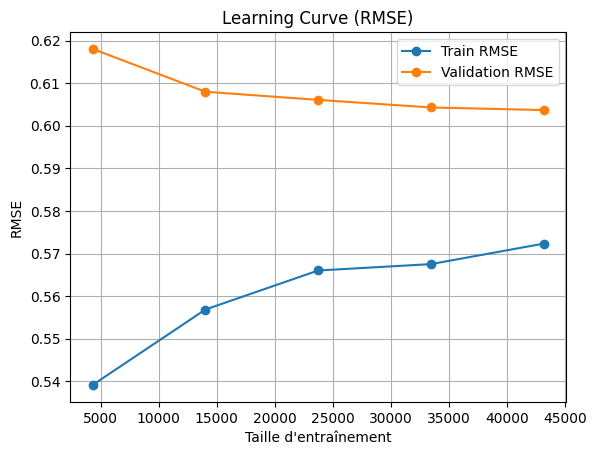

In [313]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model_1, X, y, cv=5, scoring='neg_root_mean_squared_error'
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_rmse, label='Train RMSE', marker='o')
plt.plot(train_sizes, val_rmse, label='Validation RMSE', marker='o')

plt.title('Learning Curve (RMSE)')
plt.xlabel("Taille d'entraînement")
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

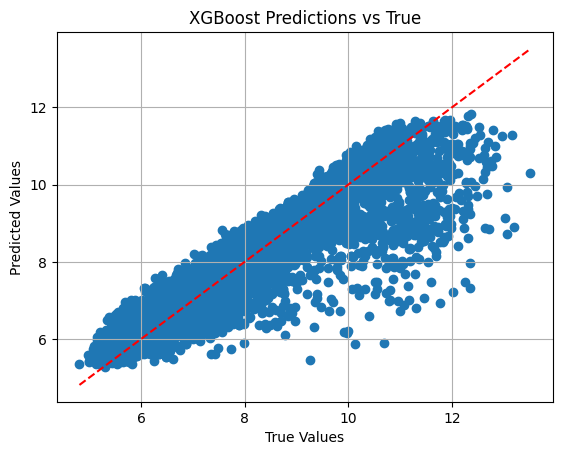

In [314]:
plt.scatter(y_val, y_pred_m1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Predictions vs True")
plt.grid(True)
plt.show()

In [315]:
df_val1 = pd.DataFrame({
    'age': X_val.Age, 
    'LogInitialIncurredCalimsCost' : X_val.LogInitialIncurredCalimsCost,
    'y_val': y_val,  
    'y_pred_m1': y_pred_m1   
})
df_val1

age  LogInitialIncurredCalimsCost      y_val  y_pred_m1
WC3790967   24                      6.781058   7.510274   7.694993
WC9722960   22                      7.824446   8.491585   8.355308
WC3120821   31                      8.160804   9.732737   8.772781
WC6621059   36                      9.047939  12.220114   9.310411
WC1757737   34                      6.216606   7.662616   7.604416
...        ...                           ...        ...        ...
WC6105641   27                      6.552508   7.245033   6.992900
WC8977061   50                     10.143410  11.358946  10.391393
WC9508520   19                      9.615872   9.265966   9.426215
WC6107284   27                      7.601402   8.157603   8.488611
WC6689491   16                      6.216606   5.565283   5.629954

[10795 rows x 4 columns]

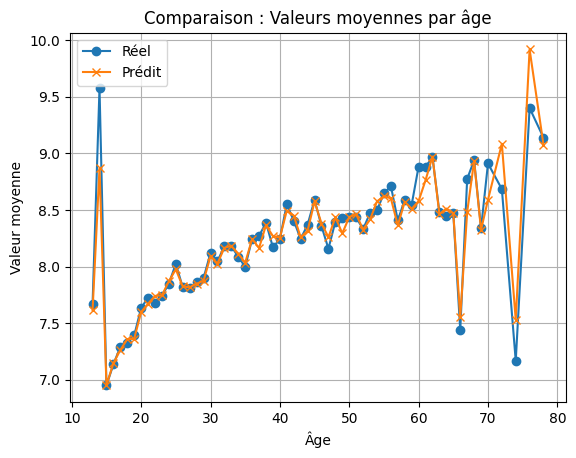

In [316]:
moyennes_par_age = df_val1.groupby('age')[['y_val', 'y_pred_m1']].mean().reset_index()
moyennes_par_age.columns = ['age', 'moyenne_reelle', 'moyenne_predite M1']
plt.plot(moyennes_par_age['age'], moyennes_par_age['moyenne_reelle'], label='Réel', marker='o')
plt.plot(moyennes_par_age['age'], moyennes_par_age['moyenne_predite M1'], label='Prédit', marker='x')
plt.xlabel("Âge")
plt.ylabel("Valeur moyenne")
plt.title("Comparaison : Valeurs moyennes par âge")
plt.legend()
plt.grid(True)
plt.show()

In [317]:
df_val1 = X_val.copy()    
df_val1['y_val'] = y_val  
df_val1['y_pred_m1'] = y_pred_m1  

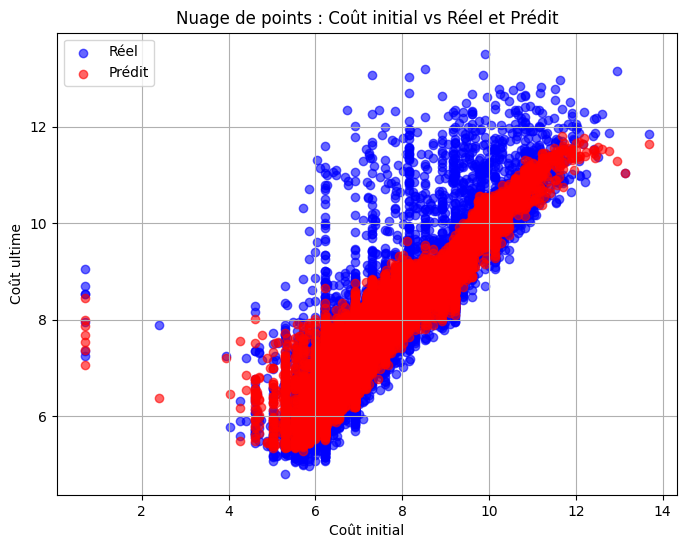

In [318]:
plt.figure(figsize=(8, 6))
plt.scatter(df_val1['LogInitialIncurredCalimsCost'], df_val1['y_val'], color='blue', alpha=0.6, label='Réel')
plt.scatter(df_val1['LogInitialIncurredCalimsCost'], df_val1['y_pred_m1'], color='red', alpha=0.6, label='Prédit')
plt.xlabel("Coût initial")
plt.ylabel("Coût ultime")
plt.title("Nuage de points : Coût initial vs Réel et Prédit")
plt.legend()
plt.grid(True)
plt.show()

In [319]:
importances = best_model_1.feature_importances_
features = X.columns  
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp.head(10))

                         feature  importance
3   LogInitialIncurredCalimsCost    0.303833
24                  cause_strain    0.141152
19                      body_eye    0.130411
10                     body_back    0.085476
26                cause_lacerate    0.042469
13                 body_shoulder    0.040038
9                    body_finger    0.026936
8                      body_hand    0.025946
23                    cause_lift    0.025033
20                     cause_cut    0.020721


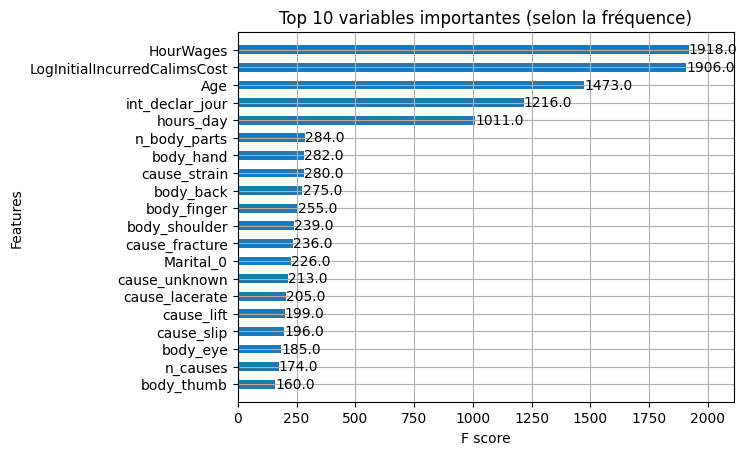

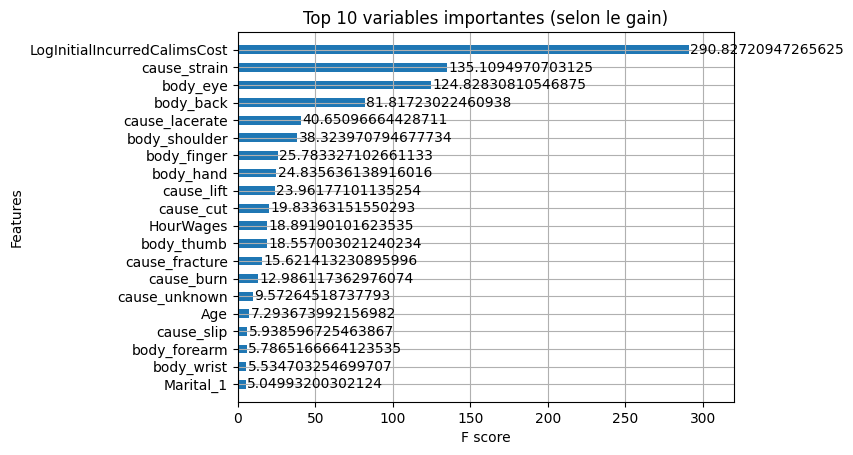

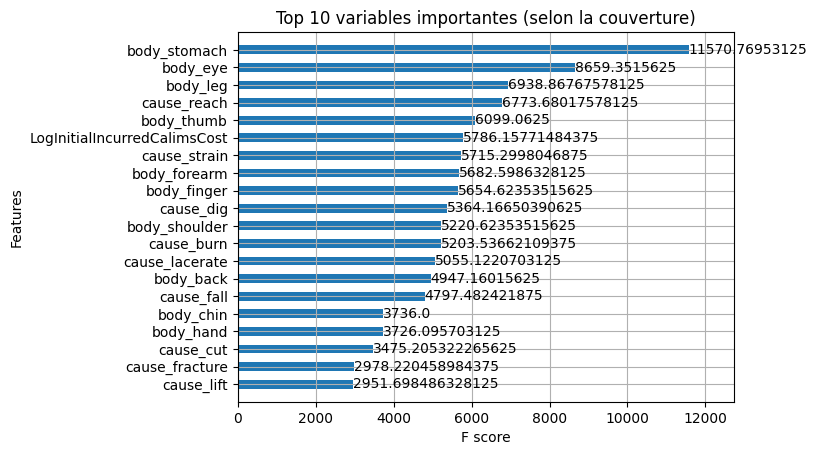

In [320]:
#weight est simple mais peut surévaluer les variables peu informatives si elles sont utilisées souvent.
plot_importance(best_model_1, importance_type='weight', max_num_features=20, height=0.5)
plt.title("Top 10 variables importantes (selon la fréquence)")
plt.grid(True)
plt.show()

#gain est généralement le plus informatif (mesure combien une feature améliore la qualité des splits).
plot_importance(best_model_1, importance_type='gain', max_num_features=20, height=0.5)
plt.title("Top 10 variables importantes (selon le gain)")
plt.grid(True)
plt.show()

#cover donne une idée de la portée de la feature.
plot_importance(best_model_1, importance_type='cover', max_num_features=20, height=0.5)
plt.title("Top 10 variables importantes (selon la couverture)")
plt.grid(True)
plt.show()

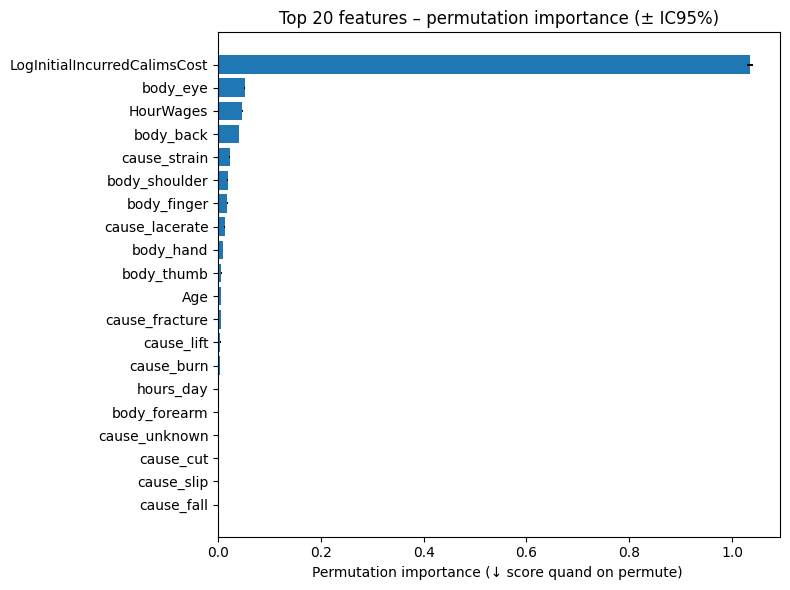

In [321]:
r = permutation_importance(best_model_1, X_val, y_val, scoring='neg_root_mean_squared_error', n_repeats=10, random_state=42)
imp_perm = pd.DataFrame({'feature': X_val.columns,
                         'importance_mean': r.importances_mean,
                         'importance_std': r.importances_std}).sort_values('importance_mean', ascending=False)

topk = 20 

top_imp = imp_perm.head(topk).sort_values('importance_mean') 

plt.figure(figsize=(8, 6))
plt.barh(top_imp['feature'], top_imp['importance_mean'], xerr=1.96 * top_imp['importance_std'] / np.sqrt(10))
plt.xlabel("Permutation importance (↓ score quand on permute) ")
plt.title(f"Top {topk} features – permutation importance (± IC95%)")
plt.tight_layout()
plt.show()


#### Grid Search CV

In [323]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.75, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=model1,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1  # pour paralléliser si possible
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
        

In [324]:
best_model_2 = grid_search.best_estimator_

best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # RMSE moyen en CV
cv_rmse_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]  # écart-type RMSE CV

df_bestp = pd.DataFrame([best_params])
df_bestp['RMSE CV'] = best_score
df_bestp['RMSE CV std'] = cv_rmse_std
df_bestp

df_bestp

learning_rate  max_depth  n_estimators  subsample   RMSE CV  RMSE CV std
0           0.05          5           200        0.6  0.602874     0.012648

In [325]:
best_params2 = grid_search.best_params_
best_score = - grid_search.best_score_
df_bestp = pd.DataFrame([best_params2])
df_bestp['mse_train'] = best_score
df_bestp

learning_rate  max_depth  n_estimators  subsample  mse_train
0           0.05          5           200        0.6   0.602874

In [326]:
best_model_2 = grid_search.best_estimator_
y_pred_m2 = best_model_2.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred_m1, squared=False)
best_params = grid_search.best_params_
data_val = best_params2.copy()
data_val['mse_val'] = rmse_val
data_val = pd.DataFrame([data_val])
data_val

learning_rate  max_depth  n_estimators  subsample  mse_val
0           0.05          5           200        0.6   0.6128

In [327]:
cv_rmse_mean = -grid_search.best_score_
cv_rmse_std  = grid_search.cv_results_['std_test_score'][random_search.best_index_]

rmse_train = mean_squared_error(y_train, best_model_2.predict(X_train), squared=False)
rmse_val   = mean_squared_error(y_val,   best_model_2.predict(X_val),   squared=False)

df_final = (pd.DataFrame([grid_search.best_params_])
            .assign(cv_rmse_mean=cv_rmse_mean,
                    cv_rmse_std=cv_rmse_std,
                    train_rmse=rmse_train,
                    val_rmse=rmse_val,
                    train_mse=rmse_train**2,
                    val_mse=rmse_val**2))

df_final.round(6)

learning_rate  max_depth  n_estimators  subsample  cv_rmse_mean  \
0           0.05          5           200        0.6      0.602874   

   cv_rmse_std  train_rmse  val_rmse  train_mse   val_mse  
0      0.01122    0.583491  0.613897   0.340462  0.376869

In [328]:
# 1) Prédictions
y_pred_train = best_model_2.predict(X_train)
y_pred_val   = best_model_2.predict(X_val)

# 2) Erreurs par observation (utile pour plots/tests)
errors_train = np.abs(y_train - y_pred_train)
errors_val   = np.abs(y_val   - y_pred_val)

# 3) Métriques globales
mse_train  = mean_squared_error(y_train, y_pred_train, squared=True)
mse_val    = mean_squared_error(y_val,   y_pred_val,   squared=True)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val   = mean_squared_error(y_val,   y_pred_val,   squared=False)

# 4) CV (à partir du RandomizedSearchCV)
cv_rmse_mean = -grid_search.best_score_
cv_rmse_std  = grid_search.cv_results_['std_test_score'][random_search.best_index_]

# 5) Gaps
gap_abs_rmse = rmse_val - rmse_train
gap_rel_rmse = gap_abs_rmse / rmse_train  # en proportion

# 6) Tableau récap
df_perf = pd.DataFrame({
    'metric':        ['MSE',      'RMSE'],
    'train':         [mse_train,   rmse_train],
    'val':           [mse_val,     rmse_val],
    'gap_abs':       [mse_val - mse_train, gap_abs_rmse],
    'gap_rel_%':     [100 * (mse_val - mse_train) / mse_train,
                      100 * gap_rel_rmse],
    'cv_rmse_mean':  [np.nan, cv_rmse_mean],
    'cv_rmse_std':   [np.nan, cv_rmse_std]
})

df_perf.round(6)

metric     train       val   gap_abs  gap_rel_%  cv_rmse_mean  cv_rmse_std
0    MSE  0.340462  0.376869  0.036407  10.693485           NaN          NaN
1   RMSE  0.583491  0.613897  0.030406   5.210971      0.602874      0.01122

In [329]:
k = grid_search.cv  # ici 5
se = cv_rmse_std / np.sqrt(k)
low  = cv_rmse_mean - 1.96 * se
high = cv_rmse_mean + 1.96 * se
print(low.round(6), high.round(6))
# Si RMSE_val est dans [low, high], rien d’anormal.

0.59304 0.612709


La RMSE_val de 0.613897 est légèrement en dehors de l'intervalle de confiance de CV_RMSE_MEAN [0.593824 ; 0.611925], cela n'a pas vraiment d'impact sur la prédiction.

In [330]:
df_val1 = X_val.copy()           
df_val1['y_val'] = y_val         
df_val1['y_pred_m1'] = y_pred_m1   
df_val1['y_pred_m2'] = y_pred_m2   

In [331]:
df_val1['y_val_eur']      = np.expm1(df_val1['y_val'])
df_val1['y_pred_m1_eur']  = np.expm1(df_val1['y_pred_m1'])
df_val1['y_pred_m2_eur']  = np.expm1(df_val1['y_pred_m2'])

# 2) Écarts (en euros)
df_val1['ecart_m1_eur']   = df_val1['y_pred_m1_eur'] - df_val1['y_val_eur']
df_val1['ecart_m2_eur']   = df_val1['y_pred_m2_eur'] - df_val1['y_val_eur']

# 3) Erreurs absolues (en euros)
df_val1['abs_err_m1_eur'] = df_val1['ecart_m1_eur'].abs()
df_val1['abs_err_m2_eur'] = df_val1['ecart_m2_eur'].abs()

# 4) Erreur relative (%) — attention aux y_val = 0
den = df_val1['y_val_eur'].replace(0, np.nan)
df_val1['pct_err_m1'] = 100 * df_val1['abs_err_m1_eur'] / den
df_val1['pct_err_m2'] = 100 * df_val1['abs_err_m2_eur'] / den

# 5) (optionnel) Quelques métriques agrégées sur l’échelle euros
rmse_m1 = mean_squared_error(df_val1['y_val_eur'], df_val1['y_pred_m1_eur'], squared=False)
mae_m1  = mean_absolute_error(df_val1['y_val_eur'], df_val1['y_pred_m1_eur'])

rmse_m2 = mean_squared_error(df_val1['y_val_eur'], df_val1['y_pred_m2_eur'], squared=False)
mae_m2  = mean_absolute_error(df_val1['y_val_eur'], df_val1['y_pred_m2_eur'])

r2_m1 = r2_score(y_val, y_pred_m2)
r2_m2 = r2_score(y_val, y_pred_m2)


print(f"[m1] RMSE (euros): {rmse_m1:,.2f} | MAE (euros): {mae_m1:,.2f} | R²: {r2_m1:,.3f}" )
print(f"[m2] RMSE (euros): {rmse_m2:,.2f} | MAE (euros): {mae_m2:,.2f} | R²: {r2_m2:,.3f}")

[m1] RMSE (euros): 24,993.40 | MAE (euros): 5,845.66 | R²: 0.838
[m2] RMSE (euros): 24,980.64 | MAE (euros): 5,836.40 | R²: 0.838


In [332]:
df_val1 = X_val.copy()         
df_val1['y_val'] = y_val         
df_val1['y_pred_xgb_rs'] = y_pred_m1   
df_val1['y_pred_xgb_gs'] = y_pred_m2
df_val1

Age  int_declar_jour  HourWages  LogInitialIncurredCalimsCost  \
WC3790967   24               14  13.082750                      6.781058   
WC9722960   22               20  15.610526                      7.824446   
WC3120821   31               38  13.657895                      8.160804   
WC6621059   36               19  18.055556                      9.047939   
WC1757737   34                4  10.092105                      6.216606   
...        ...              ...        ...                           ...   
WC6105641   27               40   3.448276                      6.552508   
WC8977061   50               33  10.785000                     10.143410   
WC9508520   19               64  12.500000                      9.615872   
WC6107284   27               27  11.842105                      7.601402   
WC6689491   16              136   5.263158                      6.216606   

           Marital_0  Marital_1  PartTimeFullTime_0  PartTimeFullTime_1  \
WC3790967          1          0                   1                   0   
WC9722960          1          0                   1                   0   
WC3120821          1          0                   1                   0   
WC6621059          0          1                   1                   0   
WC1757737          0          1                   1                   0   
...              ...        ...                 ...                 ...   
WC6105641          1          0                   1                   0   
WC8977061          0          1                   1                   0   
WC9508520          1          0                   1                   0   
WC6107284          1          0                   1                   0   
WC6689491          1          0                   1                   0   

           body_hand  body_finger  body_back  body_wrist  body_arm  \
WC3790967          0            0          0           0         0   
WC9722960          0            0          0           0         0   
WC3120821          0            0          1           0         0   
WC6621059          0            0          1           0         0   
WC1757737          0            0          1           0         0   
...              ...          ...        ...         ...       ...   
WC6105641          0            0          0           0         0   
WC8977061          0            0          1           0         0   
WC9508520          1            0          0           0         0   
WC6107284          0            0          0           0         0   
WC6689491          0            0          0           0         0   

           body_shoulder  body_thumb  body_leg  body_chin  body_stomach  \
WC3790967              1           0         0          0             0   
WC9722960              0           0         0          0             0   
WC3120821              0           0         0          0             0   
WC6621059              0           0         0          0             0   
WC1757737              0           0         0          0             0   
...                  ...         ...       ...        ...           ...   
WC6105641              0           0         0          0             0   
WC8977061              0           0         0          0             0   
WC9508520              0           0         0          0             0   
WC6107284              1           0         0          0             0   
WC6689491              0           0         0          1             0   

           body_forearm  body_eye  cause_cut  cause_slip  cause_fall  \
WC3790967             0         0          0           1           0   
WC9722960             0         0          0           0           0   
WC3120821             0         0          1           0           0   
WC6621059             0         0          0           0           0   
WC1757737             0         0          0           0           0   
...                 ...

# Validation du modèle & submission :

In [333]:
df_test = pd.read_csv("test.csv", index_col = "ClaimNumber")
df_test.drop_duplicates().shape
df_test.isnull().sum()
df_test = df_test.fillna('S')
df_test['DateTimeOfAccident'] = pd.to_datetime(df_test['DateTimeOfAccident'])
df_test['DateReported'] = pd.to_datetime(df_test['DateReported'])
df_test['annee_sinistre'] = df_test['DateTimeOfAccident'].dt.year
df_test['mois_sinistre'] = df_test['DateTimeOfAccident'].dt.month
df_test['annee_declaration'] = df_test['DateReported'].dt.year
df_test['mois_declaration'] = df_test['DateReported'].dt.month

#on ajoute le délai entre la date de sinistre et la date de déclaration de sinistre
df_test['int_declar_jour'] = (df_test['DateReported'] - df_test['DateTimeOfAccident']).dt.days
df_test['int_declar_sem'] = (df_test['DateReported'] - df_test['DateTimeOfAccident']).dt.days//7

#Salaire horraire 
df_test['HourWages'] = np.where(
    (df_test['HoursWorkedPerWeek'] > 0) & (~df_test['HoursWorkedPerWeek'].isna()),
    df_test['WeeklyWages'] / df_test['HoursWorkedPerWeek'],
    np.nan)

#transformer les deux variables pour mieux gérer les valeurs extremes
 
df_test["LogInitialIncurredCalimsCost"] = np.log1p(df_test["InitialIncurredCalimsCost"])

df_test.drop(['DateTimeOfAccident', 'DateReported'],axis=1,inplace=True)
df_test.shape
df_test['MaritalStatus_flag'] = df_test['MaritalStatus'].map({'S': 0, 'M': 1, 'U' : 1})
df_test['PartTimeFullTime_flag'] = df_test['PartTimeFullTime'].map({'F': 0, 'P': 1})

df_test = df_test.drop(['DependentChildren', 'DependentsOther', 'mois_declaration', 'mois_sinistre', 'Gender'], axis=1)

df_test = pd.get_dummies(df_test, columns=['MaritalStatus_flag'], prefix=['Marital'], drop_first=False, dtype=int)
df_test = pd.get_dummies(df_test, columns=['PartTimeFullTime_flag'], prefix=['PartTimeFullTime'], drop_first=False, dtype=int)


df_claims_desc = df_test[['ClaimDescription', 'InitialIncurredCalimsCost' ]]
 

claim_dict = df_claims_desc['ClaimDescription'].apply(extract_info).to_dict()
claim_dict = pd.DataFrame(claim_dict)

claim_dict=claim_dict.T

body_parts = ['hand', 'finger', 'back', 'wrist', 'arm', 'shoulder', 'thumb', 'leg', 'chin', 'stomach', 'forearm', 'eye']
for part in body_parts:
    claim_dict[f'body_{part}'] = claim_dict['body_part'].str.contains(part).astype(int)
    
causes = ['cut', 'slip', 'fall', 'lift', 'strain', 'burn', 'lacerate', 'fracture', 'dig', 'reach', 'unknown']
for c in causes:
    claim_dict[f'cause_{c}'] = claim_dict['cause'].str.contains(c).astype(int)
    
claim_dict['n_body_parts'] = claim_dict['body_part'].str.count(',') + 1
claim_dict['n_causes'] = claim_dict['cause'].str.count(',') + 1
claim_dict

df_concat_test = pd.concat([df_test, claim_dict], axis=1)
df_concat_test

 

df_concat_test['hours_day'] = df_concat_test['HoursWorkedPerWeek'] / df_concat_test['DaysWorkedPerWeek']

df_vf_test = df_concat_test.drop([ 'int_declar_sem', 'InitialIncurredCalimsCost',
         'WeeklyWages', 'annee_sinistre', 'annee_declaration',  'HoursWorkedPerWeek',
       'DaysWorkedPerWeek'], axis=1)

 

df_vf_test.isnull().sum()

df_vf_test = df_vf_test.dropna(subset=['HourWages'])

In [334]:
df_vf_test
df_test_copy = df_vf_test.drop(['ClaimDescription', 'cause', 'MaritalStatus', 'PartTimeFullTime', 'body_part'], axis=1)
df_test_copy.columns

Index(['Age', 'int_declar_jour', 'HourWages', 'LogInitialIncurredCalimsCost',
       'Marital_0', 'Marital_1', 'PartTimeFullTime_0', 'PartTimeFullTime_1',
       'body_hand', 'body_finger', 'body_back', 'body_wrist', 'body_arm',
       'body_shoulder', 'body_thumb', 'body_leg', 'body_chin', 'body_stomach',
       'body_forearm', 'body_eye', 'cause_cut', 'cause_slip', 'cause_fall',
       'cause_lift', 'cause_strain', 'cause_burn', 'cause_lacerate',
       'cause_fracture', 'cause_dig', 'cause_reach', 'cause_unknown',
       'n_body_parts', 'n_causes', 'hours_day'],
      dtype='object')

In [335]:
y_test_pred_m1 = best_model_1.predict(df_test_copy)
y_test_pred_m2 = best_model_2.predict(df_test_copy)

In [336]:
df_test_vf = df_test_copy.copy()        
df_test_vf['y_pred_test_xgb_rs'] = y_test_pred_m1   
df_test_vf['y_pred_test_xgb_gs'] = y_test_pred_m2
df_test_vf['y_pred_test_xgb_rs_lin'] = np.expm1(df_test_vf['y_pred_test_xgb_rs'])
df_test_vf['y_pred_test_xgb_gs_lin'] = np.expm1(df_test_vf['y_pred_test_xgb_gs'])
df_test_vf['InitialIncurredCalimsCost'] = np.expm1(df_test_vf['LogInitialIncurredCalimsCost'])
df_test_vf

Age  int_declar_jour  HourWages  LogInitialIncurredCalimsCost  \
WC8145235   26               34  15.004500                      8.575651   
WC2005111   31                8   8.901143                      7.601402   
WC6899143   57               26  26.315789                      9.903538   
WC5502023   33               39   5.263158                      5.860786   
WC4785156   32               84   8.990000                      8.006701   
...        ...              ...        ...                           ...   
WC9666858   54              127  19.440000                      9.159152   
WC4800526   22               13  12.297368                      5.993961   
WC3360567   35               11  10.253125                      8.936035   
WC7491778   45               34   5.263158                      9.210440   
WC5368443   63                4   5.263158                      5.303305   

           Marital_0  Marital_1  PartTimeFullTime_0  PartTimeFullTime_1  \
WC8145235          1          0                   1                   0   
WC2005111          0          1                   1                   0   
WC6899143          0          1                   1                   0   
WC5502023          0          1                   1                   0   
WC4785156          0          1                   1                   0   
...              ...        ...                 ...                 ...   
WC9666858          0          1                   1                   0   
WC4800526          1          0                   1                   0   
WC3360567          1          0                   0                   1   
WC7491778          0          1                   1                   0   
WC5368443          0          1                   1                   0   

           body_hand  body_finger  body_back  body_wrist  body_arm  \
WC8145235          1            0          0           0         0   
WC2005111          0            0          0           0         0   
WC6899143          1            1          0           0         0   
WC5502023          0            0          0           0         0   
WC4785156          0            0          0           0         0   
...              ...          ...        ...         ...       ...   
WC9666858          0            0          1           0         0   
WC4800526          1            0          0           0         1   
WC3360567          0            0          0           0         0   
WC7491778          0            0          1           0         0   
WC5368443          0            1          0           0         0   

           body_shoulder  body_thumb  body_leg  body_chin  body_stomach  \
WC8145235              0           0         0          0             0   
WC2005111              0           0         0          0             0   
WC6899143              0           0         0          0             0   
WC5502023              0           1         0          0             0   
WC4785156              0           0         0          0             0   
...                  ...         ...       ...        ...           ...   
WC9666858              0           0         0          0             0   
WC4800526              0           0         0          0             0   
WC3360567              0           0         0          0             0   
WC7491778              0           0         0          0             0   
WC5368443              0           0         0          0             0   

           body_forearm  body_eye  cause_cut  cause_slip  cause_fall  \
WC8145235             0         0          0           0           0   
WC2005111             0         0          0           0           0   
WC6899143             0         0          0           0           0   
WC5502023             0         0          0           0           0   
WC4785156             0         0          0           0           0   
...                 ...

In [337]:
df_test_vf[['InitialIncurredCalimsCost', 'y_pred_test_xgb_rs_lin', 'y_pred_test_xgb_gs_lin']].describe().T

count         mean           std         min  \
InitialIncurredCalimsCost  35989.0  7678.208564  17503.393496    1.000000   
y_pred_test_xgb_rs_lin     35989.0  7860.810059  12754.794922  184.747299   
y_pred_test_xgb_gs_lin     35989.0  7901.758301  12855.141602  167.916260   

                                  25%          50%          75%            max  
InitialIncurredCalimsCost  650.000000  2000.000000  9500.000000  725000.000000  
y_pred_test_xgb_rs_lin     955.337646  3384.252930  8398.142578  133040.593750  
y_pred_test_xgb_gs_lin     943.968811  3420.843262  8467.125977  140935.109375